In [1]:
# data manning
import pandas as pd
import numpy as np

# utility
import os
import random
from time import asctime
from ast import literal_eval

# language 
import nltk
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from nltk.corpus import stopwords
import string
import re
from nltk.stem.wordnet import WordNetLemmatizer
import unicodedata

# more language
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora import Dictionary
from gensim import corpora
from gensim.utils import simple_preprocess

# modeling
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity

# visualizing
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import shap
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

import xgboost 
import transformers
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics.pairwise import cosine_similarity

from time import asctime

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.model_selection import GridSearchCV

from random import randint

# paralleling
from pandarallel import pandarallel

In [2]:
pandarallel.initialize(nb_workers=3, progress_bar=True)

INFO: Pandarallel will run on 3 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
#df = pd.read_csv("../data/master-thesis-dataset-large_specChars_rm_and_wo_foods_or_keywords_wbigrams.csv")
#questions_df = pd.read_csv("../data/questions.csv")
#questions = questions_df.question.values.tolist()
#df.processed_text_tokens = df.processed_text_tokens.apply(eval)
#df = df[df.Text_Term_Count>0]

In [4]:
df = pd.read_csv("../data/master-thesis-dataset-large_specChars_rm_and_wo_foods_or_keywords_wbigrams_label.csv")
df['processed_text_tokens'] = df['processed_text_tokens'].apply(eval)
df = df[df.Text_Term_Count>0]

questions_df = pd.read_csv("../data/questions.csv")
questions = questions_df.question.values.tolist()
questions_df['processed_question_tokens'] = questions_df.processed_question_tokens.apply(eval)

In [5]:
df.head(2)

Full_Vintage_Name        Winery_Name  \
0                             Champalou Vouvray 2021          Champalou   
1  Domaine Anne Gros Clos-Vougeot Grand Cru Le Gr...  Domaine_Anne_Gros   

  Vintage_Year                            Short_Wine_Name  Type_ID  \
0         2021                                    Vouvray      2.0   
1       2017.0  Clos-Vougeot Grand Cru Le Grand Maupertui      1.0   

                   Region Country   Price Currency    Wine_ID  ...  polarity  \
0                 Vouvray  France   23.95      USD  1172337.0  ...  0.080000   
1  Clos Vougeot Grand Cru  France  290.00      USD  1137843.0  ...  0.421667   

   subjectivity Pos_or_Neg Weighted_Rating  \
0      0.520000      happy        2.252295   
1      0.762738      happy        2.750736   

                                                text  \
0  🧐 light yellow\n🤥  citrus\n😛 honey, pear, citr...   
1  🧐 When the top quality grape meets the experti...   

                                  processed_text_str  \
0  light_yellow citrus honey pear_citrus apple un...   
1  top_quality grape meet expertise winemaker get...   

                               processed_text_tokens  Text_Term_Count  \
0  [light_yellow, citrus, honey, pear_citrus, app...               14   
1  [top_quality, grape, meet, expertise, winemake...               42   

   Text_Char_Count        Label2  
0              101  Chenin_Blanc  
1              377  Burgundy_Red  

[2 rows x 52 columns]

In [6]:
#df['label'] = df.apply(lambda xyz: f'{xyz.Country} {xyz.Single_Most_Used_Grape}', axis=1)

In [7]:
df[df.Label.str.contains('Primitivo')].head()

Full_Vintage_Name         Winery_Name  \
906               Cantine Pellegrino Rinazzo Syrah 2019  Cantine_Pellegrino   
1436              Cantine Pellegrino Rinazzo Syrah 2019  Cantine_Pellegrino   
1524     Tenuta Regaleali Sallier de La Tour Syrah 2020    Tenuta_Regaleali   
2175            Feudo Montoni Vrucara Nero d'Avola 2017       Feudo_Montoni   
2839  San Marzano 62 Anniversario Primitivo di Mandu...         San_Marzano   

     Vintage_Year                                Short_Wine_Name  Type_ID  \
906          2019                                  Rinazzo Syrah      1.0   
1436         2019                                  Rinazzo Syrah      1.0   
1524         2020                       Sallier de La Tour Syrah      1.0   
2175         2017                           Vrucara Nero d'Avola      1.0   
2839         2017  62 Anniversario Primitivo di Manduria Riserva      1.0   

                     Region Country  Price Currency    Wine_ID  ...  polarity  \
906         Terre Siciliane   Italy  16.99      USD  5323538.0  ...  0.033333   
1436        Terre Siciliane   Italy  16.99      USD  5323538.0  ...  0.097396   
1524                Sicilia   Italy  15.30      USD  1510423.0  ... -0.020833   
2175                Sicilia   Italy  57.99      USD  2559031.0  ...  0.148889   
2839  Primitivo di Manduria   Italy  39.95      USD  2017637.0  ... -0.075000   

      subjectivity Pos_or_Neg Weighted_Rating  \
906       0.427778      happy        2.250135   
1436      0.477083      happy        2.500135   
1524      0.300000        sad        2.251350   
2175      0.462222      happy        2.750798   
2839      0.200000        sad        3.030556   

                                                   text  \
906   👀 medium ruby\n\n👃 medium blueberry, blueberry...   
1436  🌍\nVery decent Sicilian Syrah.\nWonderfully sm...   
1524  🇮🇹 Ruby red with purple hues, it tastes of bla...   
2175  Υπερκράσαρος! Needs some more years but it's h...   
2839  vanilla oak chocolate leather red fruit dark f...   

                                     processed_text_str  \
906   medium_ruby medium blueberry blueberry wet lea...   
1436  decent sicilian syrah wonderfully smooth soft ...   
1524  ruby_red purple_hue taste black_fruit spice fi...   
2175  need year huge aromatic complexity high_acidit...   
2839  vanilla oak chocolate leather red_fruit dark_f...   

                                  processed_text_tokens  Text_Term_Count  \
906   [medium_ruby, medium, blueberry, blueberry, we...               22   
1436  [decent, sicilian, syrah, wonderfully, smooth,...               57   
1524  [ruby_red, purple_hue, taste, black_fruit, spi...               13   
2175  [need, year, huge, aromatic, complexity, high_...               23   
2839  [vanilla, oak, chocolate, leather, red_fruit, ...               11   

      Text_Char_Count        Label2  
906               218  Shiraz/Syrah  
1436              414  Shiraz/Syrah  
1524              114  Shiraz/Syrah  
2175              199   Italian_Red  
2839               95   Italian_Red  

[5 rows x 52 columns]

In [8]:
df.groupby('Label').count()[['Full_Vintage_Name']].sort_values('Full_Vintage_Name', ascending=False)

Full_Vintage_Name
Label                                              
Spain Tempranillo                             20206
Italy Sangiovese                              17715
United States Pinot Noir                      17350
United States Cabernet Sauvignon              16249
Italy Nebbiolo                                14559
...                                             ...
New Zealand Riesling                             31
France Grenache Blanc                            28
South Africa Cabernet Sauvignon                  26
Spain Cabernet Sauvignon                         25
Austria Sauvignon Blanc                          12

[93 rows x 1 columns]

In [9]:
# max count per label is 20,000, which should be manageable

In [10]:
questions_df.head()

question  \
0  I want to split a bottle of wine with my frien...   
1  Tonight I will be eating pasta at the Italian ...   
2                  I like Cabernets from Napa Valley   
3  I'm looking to try something different for my ...   
4                          I don't know what I want.   

                              processed_question_str  \
0  want split bottle friend birthday likely eat s...   
1  tonight eat pasta italian_restaurant dinner nt...   
2                          like cabernet napa_valley   
3  look try_something_different dinner tonight wh...   
4                                       nt know want   

                           processed_question_tokens  
0  [want, split, bottle, friend, birthday, likely...  
1  [tonight, eat, pasta, italian, restaurant, din...  
2                     [like, cabernet, napa, valley]  
3  [look, try, something, different, dinner, toni...  
4                                   [nt, know, want]

# Reduce Dimensionality Based on Data Attributes

In [11]:
asctime()

'Mon May  1 11:13:35 2023'

In [12]:
df2 = pd.read_csv("../data/reduced_dimension_93Labels_dataset.csv")

In [13]:
df2.head()

processed_text_str                label  \
0  light_yellow citrus honey pear_citrus apple un...  France Chenin Blanc   
1  top_quality grape meet expertise winemaker get...    France Pinot Noir   
2  young good 42 potential become outstanding tan...       Italy Nebbiolo   
3  limited experience excellent representation ch...     Italy Sangiovese   
4  beautiful complex nicely_balance sophisticated...    France Chardonnay   

                               processed_text_tokens  Label_Cat  \
0  ['light_yellow', 'citrus', 'honey', 'pear_citr...          0   
1  ['top_quality', 'grape', 'meet', 'expertise', ...          1   
2  ['young', 'good', '42', 'potential', 'become',...          2   
3  ['limited', 'experience', 'excellent', 'repres...          3   
4  ['beautiful', 'complex', 'nicely_balance', 'so...          4   

   q1_cosine_similarity  q2_cosine_similarity  q3_cosine_similarity  \
0              0.027252              0.100711              0.071604   
1              0.032638              0.083904              0.047318   
2              0.035336              0.081676              0.047093   
3              0.033834              0.087338              0.051653   
4              0.032970              0.085925              0.060033   

   q4_cosine_similarity  q5_cosine_similarity  q6_cosine_similarity  \
0              0.051448              0.025104              0.108262   
1              0.033195              0.025349              0.243090   
2              0.032816              0.024142              0.167641   
3              0.043118              0.026572              0.195972   
4              0.037565              0.026562              0.083498   

   q7_cosine_similarity  q8_cosine_similarity  q9_cosine_similarity  \
0              0.029029              0.182450                   0.0   
1              0.147141              0.092090                   0.0   
2              0.118273              0.128446                   0.0   
3              0.126497              0.140696                   0.0   
4              0.037652              0.132038                   0.0   

   q10_cosine_similarity  q11_cosine_similarity  q12_cosine_similarity  
0               0.010127               0.032776               0.087522  
1               0.004550               0.112279               0.057793  
2               0.005088               0.095225               0.056749  
3               0.007658               0.100444               0.062317  
4               0.004765               0.037617               0.073379

In [14]:
df2.rename(columns={
    "q1_cosine_similarity":"q1_cosine_similarity_bow",
    "q2_cosine_similarity":"q2_cosine_similarity_bow",
    "q3_cosine_similarity":"q3_cosine_similarity_bow",
    "q4_cosine_similarity":"q4_cosine_similarity_bow",
    "q5_cosine_similarity":"q5_cosine_similarity_bow",
    "q6_cosine_similarity":"q6_cosine_similarity_bow",
    "q7_cosine_similarity":"q7_cosine_similarity_bow",
    "q8_cosine_similarity":"q8_cosine_similarity_bow",
    "q9_cosine_similarity":"q9_cosine_similarity_bow",
    "q10_cosine_similarity":"q10_cosine_similarity_bow",
    "q11_cosine_similarity":"q11_cosine_similarity_bow",
    "q12_cosine_similarity":"q12_cosine_similarity_bow"
}, inplace=True)

In [15]:
df2['processed_text_tokens'] = df2['processed_text_tokens'].apply(eval)

In [16]:
df2.head()

processed_text_str                label  \
0  light_yellow citrus honey pear_citrus apple un...  France Chenin Blanc   
1  top_quality grape meet expertise winemaker get...    France Pinot Noir   
2  young good 42 potential become outstanding tan...       Italy Nebbiolo   
3  limited experience excellent representation ch...     Italy Sangiovese   
4  beautiful complex nicely_balance sophisticated...    France Chardonnay   

                               processed_text_tokens  Label_Cat  \
0  [light_yellow, citrus, honey, pear_citrus, app...          0   
1  [top_quality, grape, meet, expertise, winemake...          1   
2  [young, good, 42, potential, become, outstandi...          2   
3  [limited, experience, excellent, representatio...          3   
4  [beautiful, complex, nicely_balance, sophistic...          4   

   q1_cosine_similarity_bow  q2_cosine_similarity_bow  \
0                  0.027252                  0.100711   
1                  0.032638                  0.083904   
2                  0.035336                  0.081676   
3                  0.033834                  0.087338   
4                  0.032970                  0.085925   

   q3_cosine_similarity_bow  q4_cosine_similarity_bow  \
0                  0.071604                  0.051448   
1                  0.047318                  0.033195   
2                  0.047093                  0.032816   
3                  0.051653                  0.043118   
4                  0.060033                  0.037565   

   q5_cosine_similarity_bow  q6_cosine_similarity_bow  \
0                  0.025104                  0.108262   
1                  0.025349                  0.243090   
2                  0.024142                  0.167641   
3                  0.026572                  0.195972   
4                  0.026562                  0.083498   

   q7_cosine_similarity_bow  q8_cosine_similarity_bow  \
0                  0.029029                  0.182450   
1                  0.147141                  0.092090   
2                  0.118273                  0.128446   
3                  0.126497                  0.140696   
4                  0.037652                  0.132038   

   q9_cosine_similarity_bow  q10_cosine_similarity_bow  \
0                       0.0                   0.010127   
1                       0.0                   0.004550   
2                       0.0                   0.005088   
3                       0.0                   0.007658   
4                       0.0                   0.004765   

   q11_cosine_similarity_bow  q12_cosine_similarity_bow  
0                   0.032776                   0.087522  
1                   0.112279                   0.057793  
2                   0.095225                   0.056749  
3                   0.100444                   0.062317  
4                   0.037617                   0.073379

In [17]:
asctime()

'Mon May  1 11:13:45 2023'

# Prepare for model

In [18]:
asctime()

'Mon May  1 11:13:45 2023'

In [19]:
more_stop_words = []
for grape in df2.label.unique():
    more_stop_words_label = df2[df2.label==grape].processed_text_tokens.apply(lambda xyz : [idx[0] for idx in nltk.FreqDist(xyz).most_common(1)][0]).values
    more_stop_words_label = list(set(list(more_stop_words_label)))
    more_stop_words = list(set(more_stop_words_label+more_stop_words))

In [20]:
word_counts = {}

documents = df2.processed_text_str.values.tolist() # a list of strings. one element per record. the text field.
texts = [[text for text in doc.split()] for doc in documents] # a list of list of strings.
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(line) for line in texts]
mydict = corpora.Dictionary([simple_preprocess(line) for line in documents])
corpus = [mydict.doc2bow(simple_preprocess(line)) for line in documents]

for doc in corpus:
    for id, freq in doc:
        if mydict[id] in word_counts.keys():
            word_counts[mydict[id]] += 1
        else:
            word_counts[mydict[id]] = 1

In [21]:
print('length of vocab : ', len(word_counts))
vocab = list(word_counts.keys())
distinct_question_vocab = list(set(" ".join(questions_df.question.values.tolist()).split(" "))) 
distinct_question_vocab = [word.lower() for word in distinct_question_vocab]
vocab = [word.lower() for word in vocab]
vocab = list(set(vocab + distinct_question_vocab))
print('new length of vocab : ', len(vocab))

length of vocab :  199934
new length of vocab :  199964


In [22]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1), 
                             stop_words=more_stop_words
                             ,vocabulary=vocab                             
                            )

In [23]:
text_for_counts = df2.processed_text_str.values.tolist()
matrix = vectorizer.fit_transform(text_for_counts)
words = vectorizer.get_feature_names_out()
doc_term_df = pd.DataFrame(matrix.toarray(), columns=words, index=df2.index)

In [24]:
topN_tfidf = pd.DataFrame(doc_term_df.mean().sort_values(ascending=False).head(25))
topN_tfidf.rename(columns={0: 'Mean TF-IDF'}, inplace=True)
topN_tfidf.head(25)

Mean TF-IDF
palate        0.150267
note          0.143104
dry           0.135399
nice          0.117664
acidity       0.105382
great         0.098486
light         0.094777
balance       0.086172
hint          0.085786
smooth        0.078073
red           0.077956
like          0.075992
flavor        0.075455
vanilla       0.073448
well          0.073407
medium        0.069741
tannin        0.068631
aroma         0.068524
fresh         0.067533
red_fruit     0.066400
sweet         0.066155
plum          0.064395
fruity        0.063579
spice         0.062473
ripe          0.059064

In [25]:
asctime()

'Mon May  1 11:14:19 2023'

In [26]:
doc_term_df.shape

(93, 199964)

# Test Performance

In [27]:
asctime()

'Mon May  1 11:14:19 2023'

In [28]:
#questions_df['processed_question_tokens'] = questions_df.processed_question_str.apply(lambda xyz: xyz.split())

In [29]:
processed_question_token = questions_df.processed_question_tokens[0]

question_vectorizer = vectorizer
transformed_question = question_vectorizer.fit_transform(processed_question_token)

In [30]:
transformed_question_as_array = transformed_question.toarray()
question_term_matrix = transformed_question.todense()

question_term_df = pd.DataFrame(question_term_matrix, 
                           columns=question_vectorizer.get_feature_names_out())

print(question_term_df.shape)

(10, 199964)


In [31]:
inner_doc_term_df = doc_term_df[list(question_term_df.columns)]

In [32]:
knn = NearestNeighbors(metric='cosine', 
                       algorithm='brute', 
                       n_neighbors=5, 
                       n_jobs=2)

knn.fit(inner_doc_term_df)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=2)

In [33]:
distances, indices = knn.kneighbors(question_term_df)
recs = pd.DataFrame()

In [34]:
df2.reset_index(drop=True, inplace=True)

In [35]:
for INDEX in range(len(indices)):
    df_distances = pd.DataFrame(distances[INDEX], columns=['cosine_distance_score'], index=indices[INDEX])
    df_wines = df2.iloc[indices[INDEX]]
    new_recs = df_distances.merge(df_wines, how='inner', left_index=True, right_index=True)
    recs = pd.concat([recs, new_recs])

In [36]:
df2.iloc[indices[INDEX]]

processed_text_str  \
91  well_round delicate flavour note strawberry_ra...   
85  oak blackcurrant_blackberry cedar plum black_f...   
41  2020 pinot_grigio pale_lemon_colour medium_int...   
49  session 12 4 sudtirol alto_adige alto_adige do...   
38  2021 pinot_gris pale_lemon_green_medium pronou...   

                              label  \
91                Canada Pinot Noir   
85  South Africa Cabernet Sauvignon   
41                  Italy Trebbiano   
49                 Italy Pinot Noir   
38         United States Pinot Gris   

                                processed_text_tokens  Label_Cat  \
91  [well_round, delicate, flavour, note, strawber...         91   
85  [oak, blackcurrant_blackberry, cedar, plum, bl...         85   
41  [2020, pinot_grigio, pale_lemon_colour, medium...         41   
49  [session, 12, 4, sudtirol, alto_adige, alto_ad...         49   
38  [2021, pinot_gris, pale_lemon_green_medium, pr...         38   

    q1_cosine_similarity_bow  q2_cosine_similarity_bow  \
91                  0.031039                  0.046558   
85                  0.015314                  0.091885   
41                  0.031438                  0.112945   
49                  0.032957                  0.080243   
38                  0.027516                  0.160540   

    q3_cosine_similarity_bow  q4_cosine_similarity_bow  \
91                  0.025343                  0.077596   
85                  0.025008                  0.030628   
41                  0.057043                  0.044246   
49                  0.058499                  0.042988   
38                  0.102472                  0.062553   

    q5_cosine_similarity_bow  q6_cosine_similarity_bow  \
91                  0.000000                  0.202743   
85                  0.050016                  0.100031   
41                  0.017113                  0.142607   
49                  0.023399                  0.329932   
38                  0.034588                  0.175528   

    q7_cosine_similarity_bow  q8_cosine_similarity_bow  \
91                  0.043895                  0.021948   
85                  0.064972                  0.000000   
41                  0.042814                  0.243709   
49                  0.125640                  0.097270   
38                  0.036673                  0.211921   

    q9_cosine_similarity_bow  q10_cosine_similarity_bow  \
91                       0.0                   0.000000   
85                       0.0                   0.025008   
41                       0.0                   0.017113   
49                       0.0                   0.004680   
38                       0.0                   0.012930   

    q11_cosine_similarity_bow  q12_cosine_similarity_bow  
91                   0.058527                   0.031039  
85                   0.043315                   0.030628  
41                   0.046107                   0.069863  
49                   0.101323                   0.071646  
38                   0.034714                   0.125502

In [37]:
recommendations = {}
recommendations[questions[0]] = recs

q1_recs = recommendations[questions[0]].sort_values("cosine_distance_score", ascending=False)

In [38]:
q1_recs[['cosine_distance_score', 'label']].head()

cosine_distance_score                             label
11               0.998307          United States Chardonnay
12               0.998122  United States Cabernet Sauvignon
0                0.998016               France Chenin Blanc
34               0.997986                      Italy Arneis
15               0.997694            France Sauvignon Blanc

In [39]:
asctime()

'Mon May  1 11:14:24 2023'

# XGBoost Predictions on Old World Subset

In [119]:
# creating a subset of the dataframe for faster processing times
# old world wines. of more well-known grapes.

old_world_subset = pd.concat([df[df.Country=='Italy'],
                    df[df.Country=='France'],
                    df[df.Country=='Portugal'],
                    df[df.Country=='Spain'],
                    df[df.Country=='Germany'],
                    df[df.Country=='Austria']])

old_world_subset = old_world_subset[(old_world_subset.Body_Description!='Very_light_bodied')
                               & (old_world_subset.Body_Description!='Light_bodied')
                               & (old_world_subset.Single_Most_Used_Grape!='Corvina')
                               & (old_world_subset.Single_Most_Used_Grape!='Montepulciano')
                               & (old_world_subset.Single_Most_Used_Grape!='Gouveio')
                               & (old_world_subset.Single_Most_Used_Grape!='Baga')
                               & (old_world_subset.Single_Most_Used_Grape!='Aragonez')
                               & (old_world_subset.Single_Most_Used_Grape!='Cabernet Franc')
                               & (old_world_subset.Single_Most_Used_Grape!='Touriga Nacional')
                               & (old_world_subset.Single_Most_Used_Grape!='Primitivo')]

old_world_subset = old_world_subset.groupby('Label').filter(lambda xyz: len(xyz) > 2000)
old_world_subset = old_world_subset.groupby('Label').sample(2000)

In [120]:
old_world_subset.shape

(30000, 52)

In [121]:
labels = {old_world_subset.Label.unique()[idx]:idx for idx in range(len(old_world_subset.Label.unique()))}
old_world_subset['Label_Cat'] = old_world_subset['Label'].apply(lambda xyz: labels[xyz])
y1 = old_world_subset['Label_Cat']

In [122]:
x1 = old_world_subset[['Price', 
                       'processed_text_str']]

In [44]:
clf = xgboost.XGBClassifier(random_state=8675309, seed=2, colsample_bytree=0.6, subsample=0.7)

In [123]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None, *parg, **kwarg):
        return self

    def transform(self, X):
        # returns the input as a string
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # returns the input as a dataframe
        return X[[self.key]]

In [124]:
vec_tfidf = vectorizer # TfidfVectorizer(ngram_range=(1, 1), stop_words=more_stop_words, vocabulary=vocab)

#vec_tfidf = TfidfVectorizer(ngram_range=(1,1), 
#                            analyzer='word', 
#                            stop_words=more_stop_words, 
#                            norm='l2'
#                            #, tokenizer=LemmaTokenizer()
#                           )

In [126]:
text = Pipeline([
                ('selector', TextSelector(key='processed_text_str')),
                ('vectorizer', vec_tfidf)
                ])

price = Pipeline([
                ('selector', NumberSelector(key='Price')),
                ])

feats = FeatureUnion([('processed_text_str', text),
                      ('Price', price)
                      ])

In [ ]:
pipe = Pipeline([('feats', feats),
                 ('clf', clf)
                 ])

In [48]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=0.33, random_state=8675309, stratify=y1)

In [49]:
def print_stats(preds, target, labels, sep='-', sep_len=40, fig_size=(12, 10)):
    print('Accuracy = %.2f' % metrics.accuracy_score(target, preds))
    print(sep*sep_len)
    print('Classification report:')
    print(metrics.classification_report(target, preds))
    print(sep*sep_len)
    print('Confusion matrix')
    cm = metrics.confusion_matrix(target, preds)
    cm = cm / np.sum(cm, axis=1)[:,None]
    sns.set(rc={'figure.figsize':fig_size})
    sns.heatmap(cm, 
                xticklabels=labels,
                yticklabels=labels,
                annot=True, 
                cmap = 'YlGnBu')
    plt.tight_layout()
    plt.pause(0.05)

In [50]:
asctime() # 12:25

'Sun Apr 30 14:14:33 2023'

In [51]:
param_grid = {
     'clf__n_estimators': [1000]
}

# grid search cross validation instantiation
grid_search = GridSearchCV(estimator = pipe,
                           param_grid = param_grid, 
                           cv = 2, 
                           n_jobs = 2, 
                           verbose = 1, 
                           return_train_score=True)

#hyperparameter fitting
grid_search.fit(X_train1, y_train1)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('feats',
                                        FeatureUnion(transformer_list=[('processed_text_str',
                                                                        Pipeline(steps=[('selector',
                                                                                         TextSelector(key='processed_text_str')),
                                                                                        ('vectorizer',
                                                                                         TfidfVectorizer(stop_words=['white_port',
                                                                                                                     'taste',
                                                                                                                     'bonarda',
                                                                                                                     'f

In [52]:
grid_search.cv_results_['mean_train_score']
grid_search.cv_results_['mean_test_score']

array([0.52751244])

In [53]:
grid_search.best_params_

{'clf__n_estimators': 1000}

In [54]:
clf_test = grid_search.best_estimator_

In [55]:
model = clf_test.fit(X_train1, y_train1)

In [56]:
preds = clf_test.predict(X_test1)

In [57]:
pd.options.display.float_format = "{:,.2f}".format

Accuracy = 0.57
----------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.68      0.63      0.65       712
           1       0.69      0.62      0.65       741
           2       0.55      0.52      0.54       697
           3       0.60      0.59      0.59       672
           4       0.66      0.57      0.61       759
           5       0.55      0.63      0.59       576
           6       0.42      0.40      0.41       684
           7       0.52      0.55      0.53       623
           8       0.68      0.68      0.68       665
           9       0.51      0.60      0.55       566
          10       0.64      0.55      0.59       772
          11       0.43      0.52      0.47       550
          12       0.58      0.58      0.58       659
          13       0.59      0.62      0.61       628
          14       0.39      0.43      0.41       596

    accuracy                           0.57      9900


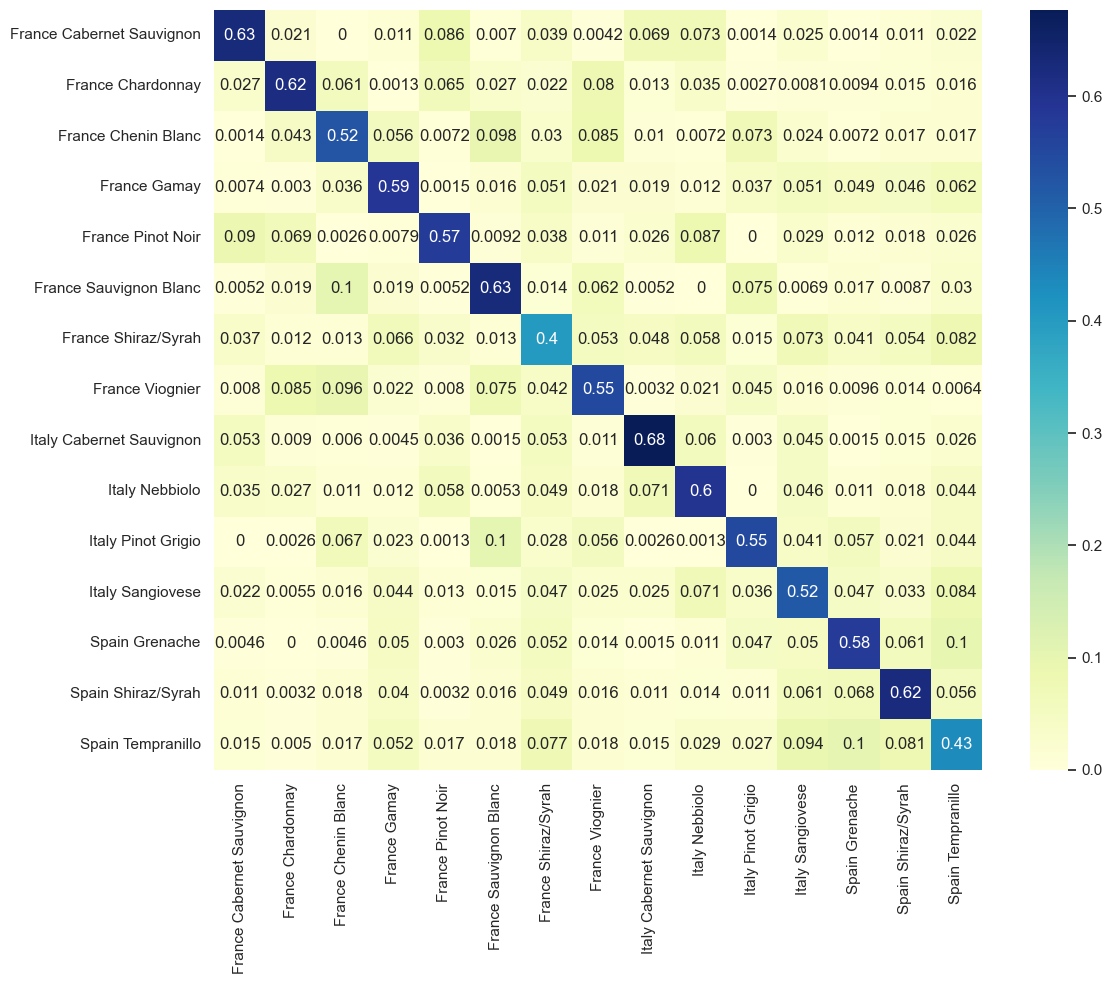

In [58]:
print_stats(y_test1, preds, labels.keys())

In [59]:
asctime()

'Sun Apr 30 16:04:53 2023'

# KNN Classifier

In [127]:
asctime()

'Mon May  1 12:51:46 2023'

In [128]:
x2 = old_world_subset[['processed_text_str']]
X_train2, X_test2, y_train2, y_test2 = train_test_split(x2, y1, test_size=0.33, random_state=8675309, stratify=y1)

In [129]:
knn_classifier = KNeighborsClassifier(metric = 'cosine', 
                       algorithm = 'brute',
                       n_neighbors = 20, 
                       n_jobs = 2)

In [130]:
feats2 = FeatureUnion([('processed_text_str', text)
                      ])

knn_class_pipe = Pipeline([('feats', feats2),
                 ('clf', knn_classifier)
                 ])

In [131]:
knn_class_pipe.fit(X_train2, y_train2)

Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('processed_text_str',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='processed_text_str')),
                                                                 ('vectorizer',
                                                                  TfidfVectorizer(stop_words=['white_port',
                                                                                              'taste',
                                                                                              'bonarda',
                                                                                              'fruit',
                                                                                              'muller',
                                                                                              'rise',
             

In [132]:
y_pred2 = knn_class_pipe.predict(X_test2) # Predicting

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


In [133]:
print(metrics.accuracy_score(y_test2, y_pred2)) 

0.3239393939393939


In [138]:
# Get the model explainer object
explainer = shap.KernelExplainer(knn_class_pipe['clf'].predict_proba, 
                                 X_train2)

# Get shap values for the test data observation whose 
# index is 0, i.e. first observation in the test set
shap_values = explainer.shap_values(X_test2[0,:], shap_explainer_type='GradientExplainer')

Provided model function fails when applied to the provided data set.


ValueError: could not convert string to float: 'citrus nose grapefruit apple_pear flavor soften honey_honeysuckle well_balance pleasant viscosity'

In [141]:
# train an XGBoost model
#X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X_train2, y_train2)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_train2, True)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:processed_text_str: object

In [ ]:
shap.plots.beeswarm(shap_values)

In [67]:
asctime()

'Sun Apr 30 16:05:35 2023'

## Explainability

In [68]:
asctime()

'Sun Apr 30 16:05:35 2023'

In [69]:
lime_explainer = LimeTextExplainer(class_names = list(labels.keys()), 
                                   bow=True, 
                                   verbose=True)

In [70]:
instance = X_test2.iloc[randint(0,len(X_test2) - 1)][0]
print(instance)

c = make_pipeline(vec_tfidf,
                  knn_class_pipe['clf']) 

please_explain = lime_explainer.explain_instance(instance, 
                                                 c.predict_proba, 
                                                 num_features=20)
please_explain.show_in_notebook()

dark_ruby_colour green_bell_pepper pepper_corn oaky note green_herb dark_fruit aroma flavour dark_fruit dark cocoa_powder date oak cloves herb 87
Intercept 0.03524422579563462
Prediction_local [-0.00561077]
Right: 0.0


In [192]:
df.columns

Index(['Full_Vintage_Name', 'Winery_Name', 'Vintage_Year', 'Short_Wine_Name',
       'Type_ID', 'Region', 'Country', 'Price', 'Currency', 'Wine_ID',
       'Average_Rating', 'Rating_Count', 'Varietal_Name', 'Body_Description',
       'Acidity_Description', 'Food_Pairings', 'Most_Used_Grapes', 'Acidity',
       'Intensity', 'Sweetness', 'Tannin', 'Primary_Keywords', 'User_Rating',
       'Note', 'Created_At', 'Label', 'Single_Most_Used_Grape',
       'Label_Category', 'Review_Term_Count', 'Type_Cat', 'Other_Grapes',
       'Acidity_Cat', 'Intensity_Cat', 'Tannin_Cat', 'Sweetness_Cat',
       'Price_Cat', 'Reasonable_Price_Winery', 'Reasonable_Price_Regional',
       'Reasonable_Price_by_Grape', 'Avg_Fair_Price', 'Relative_Price_Cat',
       'sentiments', 'polarity', 'subjectivity', 'Pos_or_Neg',
       'Weighted_Rating', 'text', 'processed_text_str',
       'processed_text_tokens', 'Text_Term_Count', 'Text_Char_Count',
       'Label2'],
      dtype='object')

In [194]:
df[df.processed_text_str==instance].Label

188565    Italy Sangiovese
Name: Label, dtype: object

In [71]:
asctime()

'Sun Apr 30 16:05:42 2023'

# Recommendations Using Raw Cosine Similarity

In [72]:
asctime()

'Sun Apr 30 16:05:42 2023'

In [73]:
processed_question1 = questions_df.loc[0, 'processed_question_str']
processed_question2 = questions_df.loc[1, 'processed_question_str']
processed_question3 = questions_df.loc[2, 'processed_question_str']
processed_question4 = questions_df.loc[3, 'processed_question_str']
processed_question5 = questions_df.loc[4, 'processed_question_str']
processed_question6 = questions_df.loc[5, 'processed_question_str']
processed_question7 = questions_df.loc[6, 'processed_question_str']
processed_question8 = questions_df.loc[7, 'processed_question_str']
processed_question9 = questions_df.loc[8, 'processed_question_str']
processed_question10 = questions_df.loc[9, 'processed_question_str']
processed_question11 = questions_df.loc[10, 'processed_question_str']
processed_question12 = questions_df.loc[11, 'processed_question_str']

In [74]:
def cosine_similarity_tfidf_method(s1, s2):
    
    # sentences to list
    allsentences = [s1 , s2]
 
    # text to vector
    all_sentences_to_vector = vectorizer.fit_transform(allsentences)
    text_to_vector_v1 = all_sentences_to_vector.toarray()[0].reshape(1,-1)
    text_to_vector_v2 = all_sentences_to_vector.toarray()[1].reshape(1,-1)
    
    # distance of similarity
    cosine = cosine_similarity(text_to_vector_v1, text_to_vector_v2)
    return cosine 

In [75]:
cosine_similarity_tfidf_method('this wine was great with tiramisu', 'i want a sweeter wine to go with dessert')

array([[0.20613697]])

In [76]:
cosine_similarity_tfidf_method('wine', 'wine')

array([[1.]])

In [77]:
cosine_similarity_tfidf_method('sweet potatoes in olive oil', 'black beans with onions and bay leaf')

array([[0.]])

In [78]:
def cos_sim_cv_q1(s1):
    cosine = cosine_similarity_tfidf_method(s1=s1, s2=processed_question1)
    return cosine[0][0]

def cos_sim_cv_q2(s1):
    cosine = cosine_similarity_tfidf_method(s1=s1, s2=processed_question2)
    return cosine[0][0]
    
def cos_sim_cv_q3(s1):
    cosine = cosine_similarity_tfidf_method(s1=s1, s2=processed_question3)
    return cosine[0][0]
    
def cos_sim_cv_q4(s1):
    cosine = cosine_similarity_tfidf_method(s1=s1, s2=processed_question4)
    return cosine[0][0]

def cos_sim_cv_q5(s1):
    cosine = cosine_similarity_tfidf_method(s1=s1, s2=processed_question5)
    return cosine[0][0]

def cos_sim_cv_q6(s1):
    cosine = cosine_similarity_tfidf_method(s1=s1, s2=processed_question6)
    return cosine[0][0]

def cos_sim_cv_q7(s1):
    cosine = cosine_similarity_tfidf_method(s1=s1, s2=processed_question7)
    return cosine[0][0]

def cos_sim_cv_q8(s1):
    cosine = cosine_similarity_tfidf_method(s1=s1, s2=processed_question8)
    return cosine[0][0]

def cos_sim_cv_q9(s1):
    cosine = cosine_similarity_tfidf_method(s1=s1, s2=processed_question9)
    return cosine[0][0]

def cos_sim_cv_q10(s1):
    cosine = cosine_similarity_tfidf_method(s1=s1, s2=processed_question10)
    return cosine[0][0]

def cos_sim_cv_q11(s1):
    cosine = cosine_similarity_tfidf_method(s1=s1, s2=processed_question11)
    return cosine[0][0]

def cos_sim_cv_q12(s1):
    cosine = cosine_similarity_tfidf_method(s1=s1, s2=processed_question12)
    return cosine[0][0]

In [79]:
asctime()

'Sun Apr 30 16:05:44 2023'

## Question 1

In [80]:
questions_df.loc[0, 'question']

'I want to split a bottle of wine with my friends for a birthday. Were all most likely eating something different for dinner.'

In [81]:
df2['q1_cosine_similarity_tfidf'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q1)

In [82]:
df2.sort_values('q1_cosine_similarity_tfidf', ascending=False).head(20)[['q1_cosine_similarity_tfidf','label']]

q1_cosine_similarity_tfidf                             label
74                        0.04               Canada Shiraz/Syrah
12                        0.04  United States Cabernet Sauvignon
13                        0.03         Portugal Touriga Nacional
29                        0.03          Italy Cabernet Sauvignon
89                        0.03      Australia Cabernet Sauvignon
21                        0.03                     Italy Corvina
63                        0.03               Italy Montepulciano
24                        0.03         France Cabernet Sauvignon
2                         0.03                    Italy Nebbiolo
3                         0.02                  Italy Sangiovese
28                        0.02          Chile Cabernet Sauvignon
4                         0.02                 France Chardonnay
46                        0.02        United States Shiraz/Syrah
7                         0.02            Australia Shiraz/Syrah
43                        0.02               France Shiraz/Syrah
25                        0.02          United States Pinot Noir
1                         0.02                 France Pinot Noir
37                        0.02        United States Chenin Blanc
8                         0.02      Argentina Cabernet Sauvignon
66                        0.02                   Italy Primitivo

In [83]:
df2.sort_values('q1_cosine_similarity_tfidf', ascending=False).head(5).label.unique()

array(['Canada Shiraz/Syrah', 'United States Cabernet Sauvignon',
       'Portugal Touriga Nacional', 'Italy Cabernet Sauvignon',
       'Australia Cabernet Sauvignon'], dtype=object)

In [84]:
asctime()

'Sun Apr 30 16:06:09 2023'

## Question 2

In [85]:
questions_df.loc[1, 'question']

"Tonight I will be eating pasta at the Italian restaurant for dinner. I don't like sweet wines."

In [86]:
df2['q2_cosine_similarity_tfidf'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q2)

In [87]:
df2.sort_values('q2_cosine_similarity_tfidf', ascending=False).head(20)[['q2_cosine_similarity_tfidf','label']]

q2_cosine_similarity_tfidf                          label
42                        0.16         United States Riesling
13                        0.14      Portugal Touriga Nacional
75                        0.12           Australia Pinot Gris
36                        0.12               Portugal Gouveio
38                        0.12       United States Pinot Gris
17                        0.11               Germany Riesling
56                        0.10              France Pinot Gris
10                        0.09             Italy Pinot Grigio
37                        0.09     United States Chenin Blanc
21                        0.09                  Italy Corvina
35                        0.08          Chile Sauvignon Blanc
46                        0.08     United States Shiraz/Syrah
71                        0.08                 Italy Malvasia
66                        0.08                Italy Primitivo
61                        0.08         New Zealand Pinot Gris
26                        0.08  United States Sauvignon Blanc
11                        0.08       United States Chardonnay
41                        0.08                Italy Trebbiano
78                        0.08                  Portugal Baga
32                        0.07                 Spain Grenache

In [88]:
df2.sort_values('q2_cosine_similarity_tfidf', ascending=False).head(5).label.unique()

array(['United States Riesling', 'Portugal Touriga Nacional',
       'Australia Pinot Gris', 'Portugal Gouveio',
       'United States Pinot Gris'], dtype=object)

## Question 3

In [89]:
questions_df.loc[2, 'question']

'I like Cabernets from Napa Valley'

In [90]:
df2['q3_cosine_similarity_tfidf'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q3)

In [91]:
df2.sort_values('q3_cosine_similarity_tfidf', ascending=False).head(20)[['q3_cosine_similarity_tfidf','label']]

q3_cosine_similarity_tfidf                             label
92                        0.08             France Grenache Blanc
26                        0.07     United States Sauvignon Blanc
11                        0.07          United States Chardonnay
75                        0.07              Australia Pinot Gris
12                        0.07  United States Cabernet Sauvignon
35                        0.07             Chile Sauvignon Blanc
38                        0.06          United States Pinot Gris
8                         0.06      Argentina Cabernet Sauvignon
72                        0.06              Italy Gewürztraminer
42                        0.06            United States Riesling
46                        0.06        United States Shiraz/Syrah
25                        0.06          United States Pinot Noir
37                        0.05        United States Chenin Blanc
89                        0.05      Australia Cabernet Sauvignon
58                        0.05                 Portugal Malvasia
10                        0.05                Italy Pinot Grigio
82                        0.05                   France Grenache
48                        0.05              Italy Müller-Thurgau
71                        0.05                    Italy Malvasia
80                        0.05           Austria Sauvignon Blanc

In [92]:
df2.sort_values('q3_cosine_similarity_tfidf', ascending=False).head(5).label.unique()

array(['France Grenache Blanc', 'United States Sauvignon Blanc',
       'United States Chardonnay', 'Australia Pinot Gris',
       'United States Cabernet Sauvignon'], dtype=object)

## Question 4

In [93]:
questions_df.loc[3, 'question']

"I'm looking to try something different for my dinner tonight. I'm having a white fish and tend to go for acidic white wines."

In [94]:
df2['q4_cosine_similarity_tfidf'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q4)

In [95]:
df2.sort_values('q4_cosine_similarity_tfidf', ascending=False).head(20)[['q4_cosine_similarity_tfidf','label']]

q4_cosine_similarity_tfidf                          label
71                        0.05                 Italy Malvasia
18                        0.05      France Melon de Bourgogne
33                        0.05    New Zealand Sauvignon Blanc
10                        0.05             Italy Pinot Grigio
88                        0.05      Australia Sauvignon Blanc
38                        0.04       United States Pinot Gris
91                        0.04              Canada Pinot Noir
26                        0.04  United States Sauvignon Blanc
35                        0.04          Chile Sauvignon Blanc
20                        0.04     Portugal Arinto de Bucelas
77                        0.04             Australia Grenache
0                         0.04            France Chenin Blanc
42                        0.04         United States Riesling
15                        0.04         France Sauvignon Blanc
37                        0.03     United States Chenin Blanc
63                        0.03            Italy Montepulciano
75                        0.03           Australia Pinot Gris
56                        0.03              France Pinot Gris
61                        0.03         New Zealand Pinot Gris
89                        0.03   Australia Cabernet Sauvignon

In [96]:
df2.sort_values('q4_cosine_similarity_tfidf', ascending=False).head(5).label.unique()

array(['Italy Malvasia', 'France Melon de Bourgogne',
       'New Zealand Sauvignon Blanc', 'Italy Pinot Grigio',
       'Australia Sauvignon Blanc'], dtype=object)

## Question 5

In [97]:
questions_df.loc[4, 'question']

"I don't know what I want."

In [98]:
df2['q5_cosine_similarity_tfidf'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q5)

In [99]:
df2.sort_values('q5_cosine_similarity_tfidf', ascending=False).head(20)[['q5_cosine_similarity_tfidf','label']]

q5_cosine_similarity_tfidf                             label
75                        0.04              Australia Pinot Gris
57                        0.04              Argentina Pinot Gris
79                        0.03          New Zealand Shiraz/Syrah
60                        0.03                Australia Riesling
89                        0.03      Australia Cabernet Sauvignon
77                        0.03                Australia Grenache
19                        0.03               Israel Shiraz/Syrah
63                        0.03               Italy Montepulciano
69                        0.03             France Cabernet Franc
85                        0.03   South Africa Cabernet Sauvignon
37                        0.03        United States Chenin Blanc
42                        0.03            United States Riesling
81                        0.03           South Africa Pinot Gris
70                        0.03             Argentina Tempranillo
38                        0.02          United States Pinot Gris
12                        0.02  United States Cabernet Sauvignon
28                        0.02          Chile Cabernet Sauvignon
71                        0.02                    Italy Malvasia
7                         0.02            Australia Shiraz/Syrah
10                        0.02                Italy Pinot Grigio

In [100]:
df2.sort_values('q5_cosine_similarity_tfidf', ascending=False).head(5).label.unique()

array(['Australia Pinot Gris', 'Argentina Pinot Gris',
       'New Zealand Shiraz/Syrah', 'Australia Riesling',
       'Australia Cabernet Sauvignon'], dtype=object)

## Question 6

In [101]:
questions_df.loc[5, 'question']

'Do you have a red wine that is light? Not too heavy.'

In [102]:
df2['q6_cosine_similarity_tfidf'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q6)

In [103]:
df2.sort_values('q6_cosine_similarity_tfidf', ascending=False).head(20)[['q6_cosine_similarity_tfidf','label']]

q6_cosine_similarity_tfidf                     label
49                        0.25          Italy Pinot Noir
5                         0.21              France Gamay
54                        0.21        Germany Pinot Noir
69                        0.20     France Cabernet Franc
22                        0.19    New Zealand Pinot Noir
32                        0.19            Spain Grenache
1                         0.18         France Pinot Noir
25                        0.17  United States Pinot Noir
59                        0.17      Argentina Pinot Noir
55                        0.17   South Africa Pinot Noir
44                        0.17            Italy Grenache
65                        0.16      Australia Pinot Noir
75                        0.15      Australia Pinot Gris
51                        0.15          Chile Pinot Noir
14                        0.15        Spain Shiraz/Syrah
78                        0.14             Portugal Baga
10                        0.14        Italy Pinot Grigio
3                         0.14          Italy Sangiovese
71                        0.13            Italy Malvasia
66                        0.13           Italy Primitivo

In [104]:
df2.sort_values('q6_cosine_similarity_tfidf', ascending=False).head(5).label.unique()

array(['Italy Pinot Noir', 'France Gamay', 'Germany Pinot Noir',
       'France Cabernet Franc', 'New Zealand Pinot Noir'], dtype=object)

## Question 7

In [105]:
questions_df.loc[6, 'question']

'Do you have any heavy flavorful red wines?'

In [106]:
df2['q7_cosine_similarity_tfidf'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q7)

In [107]:
df2.sort_values('q7_cosine_similarity_tfidf', ascending=False).head(20)[['q7_cosine_similarity_tfidf','label']]

q7_cosine_similarity_tfidf                         label
78                        0.12                 Portugal Baga
32                        0.11                Spain Grenache
14                        0.11            Spain Shiraz/Syrah
1                         0.11             France Pinot Noir
69                        0.11         France Cabernet Franc
5                         0.10                  France Gamay
44                        0.10                Italy Grenache
70                        0.10         Argentina Tempranillo
64                        0.10            Chile Shiraz/Syrah
65                        0.09          Australia Pinot Noir
22                        0.09        New Zealand Pinot Noir
3                         0.09              Italy Sangiovese
6                         0.09             Spain Tempranillo
49                        0.09              Italy Pinot Noir
66                        0.09               Italy Primitivo
30                        0.09     South Africa Shiraz/Syrah
29                        0.09      Italy Cabernet Sauvignon
2                         0.08                Italy Nebbiolo
28                        0.08      Chile Cabernet Sauvignon
8                         0.08  Argentina Cabernet Sauvignon

In [108]:
df2.sort_values('q7_cosine_similarity_tfidf', ascending=False).head(5).label.unique()

array(['Portugal Baga', 'Spain Grenache', 'Spain Shiraz/Syrah',
       'France Pinot Noir', 'France Cabernet Franc'], dtype=object)

## Question 8

In [109]:
questions_df.loc[7, 'question']

"I am looking for a dry white wine that's easy to drink."

In [110]:
df2['q8_cosine_similarity_tfidf'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q8)

In [111]:
df2.sort_values('q8_cosine_similarity_tfidf', ascending=False).head(20)[['q8_cosine_similarity_tfidf','label']]

q8_cosine_similarity_tfidf                       label
58                        0.21           Portugal Malvasia
36                        0.18            Portugal Gouveio
57                        0.18        Argentina Pinot Gris
18                        0.18   France Melon de Bourgogne
10                        0.18          Italy Pinot Grigio
15                        0.18      France Sauvignon Blanc
41                        0.18             Italy Trebbiano
45                        0.18             France Viognier
37                        0.17  United States Chenin Blanc
71                        0.17              Italy Malvasia
42                        0.17      United States Riesling
20                        0.17  Portugal Arinto de Bucelas
75                        0.16        Australia Pinot Gris
56                        0.16           France Pinot Gris
38                        0.15    United States Pinot Gris
9                         0.15             France Riesling
60                        0.14          Australia Riesling
76                        0.14          Germany Pinot Gris
34                        0.14                Italy Arneis
35                        0.13       Chile Sauvignon Blanc

In [112]:
df2.sort_values('q8_cosine_similarity_tfidf', ascending=False).head(5).label.unique()

array(['Portugal Malvasia', 'Portugal Gouveio', 'Argentina Pinot Gris',
       'France Melon de Bourgogne', 'Italy Pinot Grigio'], dtype=object)

## Question 9

In [113]:
questions_df.loc[8, 'question']

'Wine is for snobs'

In [114]:
df2['q9_cosine_similarity_tfidf'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q9)

In [115]:
df2.sort_values('q9_cosine_similarity_tfidf', ascending=False).head(20)[['q9_cosine_similarity_tfidf','label']]

q9_cosine_similarity_tfidf                             label
82                        0.01                   France Grenache
39                        0.00             Spain Sauvignon Blanc
20                        0.00        Portugal Arinto de Bucelas
14                        0.00                Spain Shiraz/Syrah
46                        0.00        United States Shiraz/Syrah
43                        0.00               France Shiraz/Syrah
45                        0.00                   France Viognier
25                        0.00          United States Pinot Noir
10                        0.00                Italy Pinot Grigio
12                        0.00  United States Cabernet Sauvignon
23                        0.00                  Argentina Malbec
85                        0.00   South Africa Cabernet Sauvignon
60                        0.00                Australia Riesling
66                        0.00                   Italy Primitivo
65                        0.00              Australia Pinot Noir
64                        0.00                Chile Shiraz/Syrah
63                        0.00               Italy Montepulciano
62                        0.00            Argentina Shiraz/Syrah
61                        0.00            New Zealand Pinot Gris
89                        0.00      Australia Cabernet Sauvignon

In [116]:
df2.sort_values('q9_cosine_similarity_tfidf', ascending=False).head(5).label.unique()

array(['France Grenache', 'Spain Sauvignon Blanc',
       'Portugal Arinto de Bucelas', 'Spain Shiraz/Syrah',
       'United States Shiraz/Syrah'], dtype=object)

## Question 10

In [117]:
questions_df.loc[9, 'question']

'I am not normally a wine drinker. What do you recommend?'

In [118]:
df2['q10_cosine_similarity_tfidf'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q10)

In [119]:
df2.sort_values('q10_cosine_similarity_tfidf', ascending=False).head(20)[['q10_cosine_similarity_tfidf','label']]

q10_cosine_similarity_tfidf                            label
53                         0.03           Argentina Petit Verdot
82                         0.01                  France Grenache
85                         0.01  South Africa Cabernet Sauvignon
71                         0.01                   Italy Malvasia
31                         0.01                 Chile Chardonnay
41                         0.01                  Italy Trebbiano
92                         0.01            France Grenache Blanc
28                         0.01         Chile Cabernet Sauvignon
38                         0.01         United States Pinot Gris
75                         0.01             Australia Pinot Gris
66                         0.01                  Italy Primitivo
34                         0.01                     Italy Arneis
10                         0.01               Italy Pinot Grigio
26                         0.01    United States Sauvignon Blanc
69                         0.01            France Cabernet Franc
11                         0.01         United States Chardonnay
50                         0.01         Argentina Cabernet Franc
25                         0.01         United States Pinot Noir
15                         0.01           France Sauvignon Blanc
88                         0.01        Australia Sauvignon Blanc

In [120]:
df2.sort_values('q10_cosine_similarity_tfidf', ascending=False).head(5).label.unique()

array(['Argentina Petit Verdot', 'France Grenache',
       'South Africa Cabernet Sauvignon', 'Italy Malvasia',
       'Chile Chardonnay'], dtype=object)

## Question 11

In [121]:
questions_df.loc[10, 'question']

'I want to split a bottle of red wine with my friends for a birthday. Were all most likely eating something different for dinner.'

In [122]:
df2['q11_cosine_similarity_tfidf'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q11)

In [123]:
df2.sort_values('q11_cosine_similarity_tfidf', ascending=False).head(20)[['q11_cosine_similarity_tfidf','label']].reset_index()

index  q11_cosine_similarity_tfidf                      label
0       1                         0.08          France Pinot Noir
1       5                         0.08               France Gamay
2      32                         0.07             Spain Grenache
3      44                         0.07             Italy Grenache
4       3                         0.07           Italy Sangiovese
5      14                         0.07         Spain Shiraz/Syrah
6      29                         0.07   Italy Cabernet Sauvignon
7       2                         0.07             Italy Nebbiolo
8      78                         0.07              Portugal Baga
9      66                         0.07            Italy Primitivo
10     69                         0.07      France Cabernet Franc
11      6                         0.06          Spain Tempranillo
12     49                         0.06           Italy Pinot Noir
13     74                         0.06        Canada Shiraz/Syrah
14     22                         0.06     New Zealand Pinot Noir
15     43                         0.06        France Shiraz/Syrah
16     28                         0.06   Chile Cabernet Sauvignon
17     25                         0.06   United States Pinot Noir
18     70                         0.06      Argentina Tempranillo
19     30                         0.06  South Africa Shiraz/Syrah

In [124]:
df2.sort_values('q11_cosine_similarity_tfidf', ascending=False).head(5).label.unique()

array(['France Pinot Noir', 'France Gamay', 'Spain Grenache',
       'Italy Grenache', 'Italy Sangiovese'], dtype=object)

## Question 12

In [125]:
questions_df.loc[11, 'question']

'I like Cabernet Sauvignon s from Napa Valley'

In [126]:
df2['q12_cosine_similarity_tfidf'] = df2.processed_text_str.parallel_apply(cos_sim_cv_q12)

In [127]:
df2.sort_values('q12_cosine_similarity_tfidf', ascending=False).head(20)[['q12_cosine_similarity_tfidf','label']].reset_index()

index  q12_cosine_similarity_tfidf                             label
0      92                         0.10             France Grenache Blanc
1      75                         0.09              Australia Pinot Gris
2      38                         0.09          United States Pinot Gris
3      26                         0.09     United States Sauvignon Blanc
4      11                         0.09          United States Chardonnay
5      42                         0.08            United States Riesling
6      35                         0.08             Chile Sauvignon Blanc
7      72                         0.08              Italy Gewürztraminer
8      37                         0.08        United States Chenin Blanc
9      46                         0.07        United States Shiraz/Syrah
10     25                         0.07          United States Pinot Noir
11     58                         0.07                 Portugal Malvasia
12     31                         0.06                  Chile Chardonnay
13     82                         0.06                   France Grenache
14     48                         0.06              Italy Müller-Thurgau
15     71                         0.06                    Italy Malvasia
16     80                         0.06           Austria Sauvignon Blanc
17      5                         0.06                      France Gamay
18     10                         0.06                Italy Pinot Grigio
19     12                         0.06  United States Cabernet Sauvignon

In [128]:
df2.sort_values('q12_cosine_similarity_tfidf', ascending=False).head(5).label.unique()

array(['France Grenache Blanc', 'Australia Pinot Gris',
       'United States Pinot Gris', 'United States Sauvignon Blanc',
       'United States Chardonnay'], dtype=object)

In [129]:
asctime()

'Sun Apr 30 16:10:41 2023'

# KNN

In [130]:
asctime()

'Sun Apr 30 16:10:42 2023'

In [131]:
interesting_columns = ['cosine_distance_score', 'label']
recommendations = {}
similarity_list = []
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5, n_jobs=2) # n_jobs -1
question_vectorizer = vectorizer

In [132]:
question = questions_df.loc[0, 'question']
question_tokens = questions_df.loc[0, 'processed_question_tokens']
transformed_question = question_vectorizer.fit_transform(question_tokens)

transformed_question_as_array = transformed_question.toarray()
question_term_matrix = transformed_question.todense()

question_term_df = pd.DataFrame(question_term_matrix, 
                           columns=question_vectorizer.get_feature_names_out())

print(question_term_df.shape)

(10, 199964)


In [133]:
doc_term_df.shape

(93, 199964)

In [134]:
knn.fit(doc_term_df)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=2)

In [135]:
for idx, question in enumerate(questions):
    print(questions_df.question.iloc[idx])
    question_tokens = questions_df.loc[idx, 'processed_question_tokens']
    transformed_question = question_vectorizer.fit_transform(question_tokens)
    
    # bc sparse; reduces dimensionality
    transformed_question_as_array = transformed_question.toarray()
    question_term_matrix = transformed_question.todense()
    question_term_df = pd.DataFrame(question_term_matrix, 
                               columns=question_vectorizer.get_feature_names_out())
    
    #https://scikit-learn.org/stable/modules/neighbors.html
#    knn.fit(doc_term_df[list(question_term_df.columns)])
    distances, indices = knn.kneighbors(question_term_df)
    
    recs = pd.DataFrame()
    for INDEX in range(len(indices)): # number of iterations as length of question
        df_distances = pd.DataFrame(distances[INDEX], columns=['cosine_distance_score'], index=indices[INDEX])
        df_wines = df2.iloc[indices[INDEX]] # df_wines = df2.iloc[indices[INDEX]]
        new_recs = df_distances.merge(df_wines, how='inner', left_index=True, right_index=True) # shape of 5 neighbs
        recs = pd.concat([recs, new_recs]) # size of question length * 5
    recommendations[question] = recs

I want to split a bottle of wine with my friends for a birthday. Were all most likely eating something different for dinner.
Tonight I will be eating pasta at the Italian restaurant for dinner. I don't like sweet wines.
I like Cabernets from Napa Valley
I'm looking to try something different for my dinner tonight. I'm having a white fish and tend to go for acidic white wines.
I don't know what I want.
Do you have a red wine that is light? Not too heavy.
Do you have any heavy flavorful red wines?
I am looking for a dry white wine that's easy to drink.
Wine is for snobs
I am not normally a wine drinker. What do you recommend?
I want to split a bottle of red wine with my friends for a birthday. Were all most likely eating something different for dinner.
I like Cabernet Sauvignon s from Napa Valley


In [136]:
asctime()

'Sun Apr 30 16:11:32 2023'

## Question 12

In [137]:
questions[-1]

'I like Cabernet Sauvignon s from Napa Valley'

In [138]:
print(len(indices))

5


In [139]:
recommendations[questions[-1]].shape

(25, 29)

In [140]:
recommendations[questions[-1]][interesting_columns].drop_duplicates('label').sort_values('cosine_distance_score', ascending=False).head(20).reset_index()

index  cosine_distance_score                             label
0      25                   0.98          United States Pinot Noir
1      37                   0.98        United States Chenin Blanc
2      31                   0.97                  Chile Chardonnay
3      68                   0.97         Israel Cabernet Sauvignon
4      64                   0.96                Chile Shiraz/Syrah
5      51                   0.96                  Chile Pinot Noir
6      35                   0.96             Chile Sauvignon Blanc
7      73                   0.96           Germany Sauvignon Blanc
8      28                   0.95          Chile Cabernet Sauvignon
9      15                   0.94            France Sauvignon Blanc
10     26                   0.91     United States Sauvignon Blanc
11     83                   0.91      South Africa Sauvignon Blanc
12     12                   0.91  United States Cabernet Sauvignon
13      8                   0.90      Argentina Cabernet Sauvignon
14     39                   0.88             Spain Sauvignon Blanc
15     89                   0.88      Australia Cabernet Sauvignon
16     11                   0.87          United States Chardonnay
17     42                   0.86            United States Riesling
18     38                   0.85          United States Pinot Gris
19     92                   0.84             France Grenache Blanc

## Question 11

In [141]:
questions[-2]

'I want to split a bottle of red wine with my friends for a birthday. Were all most likely eating something different for dinner.'

In [142]:
recommendations[questions[-2]].drop_duplicates('label').sort_values("cosine_distance_score", ascending=False).head(20)[interesting_columns].reset_index()

index  cosine_distance_score                             label
0      11                   1.00          United States Chardonnay
1       0                   1.00               France Chenin Blanc
2      34                   1.00                      Italy Arneis
3      15                   1.00            France Sauvignon Blanc
4      59                   0.99              Argentina Pinot Noir
5      37                   0.99        United States Chenin Blanc
6      46                   0.99        United States Shiraz/Syrah
7      28                   0.99          Chile Cabernet Sauvignon
8      83                   0.99      South Africa Sauvignon Blanc
9      21                   0.99                     Italy Corvina
10     64                   0.99                Chile Shiraz/Syrah
11      8                   0.99      Argentina Cabernet Sauvignon
12     89                   0.98      Australia Cabernet Sauvignon
13     57                   0.98              Argentina Pinot Gris
14     12                   0.98  United States Cabernet Sauvignon
15     73                   0.98           Germany Sauvignon Blanc
16     79                   0.98          New Zealand Shiraz/Syrah
17     74                   0.98               Canada Shiraz/Syrah
18     81                   0.98           South Africa Pinot Gris
19     38                   0.98          United States Pinot Gris

## Question 10

In [143]:
questions[-3]

'I am not normally a wine drinker. What do you recommend?'

In [144]:
recommendations[questions[-3]].drop_duplicates('label').sort_values("cosine_distance_score", ascending=False).head(20)[interesting_columns].reset_index()

index  cosine_distance_score                            label
0      41                   0.99                  Italy Trebbiano
1      31                   0.99                 Chile Chardonnay
2      26                   0.99    United States Sauvignon Blanc
3      71                   0.99                   Italy Malvasia
4      78                   0.99                    Portugal Baga
5      11                   0.99         United States Chardonnay
6      38                   0.99         United States Pinot Gris
7      82                   0.99                  France Grenache
8      66                   0.98                  Italy Primitivo
9      53                   0.98           Argentina Petit Verdot
10     28                   0.97         Chile Cabernet Sauvignon
11     92                   0.97            France Grenache Blanc
12     85                   0.97  South Africa Cabernet Sauvignon

## Question 9

In [145]:
questions[-4]

'Wine is for snobs'

In [146]:
recommendations[questions[-4]].drop_duplicates('label').sort_values("cosine_distance_score", ascending=False).head(20)[interesting_columns].reset_index()

index  cosine_distance_score                       label
0     14                   1.00          Spain Shiraz/Syrah
1     46                   1.00  United States Shiraz/Syrah
2     20                   1.00  Portugal Arinto de Bucelas
3     39                   0.99       Spain Sauvignon Blanc
4     82                   0.97             France Grenache

## Question 8

In [147]:
questions[-5]

"I am looking for a dry white wine that's easy to drink."

In [148]:
recommendations[questions[-5]].drop_duplicates('label').sort_values("cosine_distance_score", ascending=False).head(20)[interesting_columns].reset_index()

index  cosine_distance_score                      label
0      10                   0.99         Italy Pinot Grigio
1      57                   0.98       Argentina Pinot Gris
2      75                   0.98       Australia Pinot Gris
3      49                   0.97           Italy Pinot Noir
4      81                   0.97    South Africa Pinot Gris
5      77                   0.97         Australia Grenache
6      84                   0.96   Spain Cabernet Sauvignon
7      79                   0.96   New Zealand Shiraz/Syrah
8      82                   0.93            France Grenache
9      80                   0.92    Austria Sauvignon Blanc
10     24                   0.92  France Cabernet Sauvignon
11     34                   0.82               Italy Arneis
12     15                   0.80     France Sauvignon Blanc
13     58                   0.77          Portugal Malvasia
14     45                   0.75            France Viognier
15     21                   0.75              Italy Corvina
16     36                   0.74           Portugal Gouveio
17      9                   0.74            France Riesling
18     60                   0.73         Australia Riesling
19     41                   0.73            Italy Trebbiano

## Question 7

In [149]:
questions[-6]

'Do you have any heavy flavorful red wines?'

In [150]:
recommendations[questions[-6]].drop_duplicates('label').sort_values("cosine_distance_score", ascending=False).head(20)[interesting_columns].reset_index()

index  cosine_distance_score                             label
0      64                   0.99                Chile Shiraz/Syrah
1      65                   0.98              Australia Pinot Noir
2      57                   0.98              Argentina Pinot Gris
3      71                   0.98                    Italy Malvasia
4      82                   0.97                   France Grenache
5      23                   0.97                  Argentina Malbec
6      69                   0.96             France Cabernet Franc
7      46                   0.96        United States Shiraz/Syrah
8      11                   0.96          United States Chardonnay
9      63                   0.96               Italy Montepulciano
10     21                   0.96                     Italy Corvina
11     12                   0.96  United States Cabernet Sauvignon
12     32                   0.80                    Spain Grenache
13     78                   0.80                     Portugal Baga
14     22                   0.80            New Zealand Pinot Noir
15      1                   0.78                 France Pinot Noir

## Question 6

In [151]:
questions[-7]

'Do you have a red wine that is light? Not too heavy.'

In [152]:
recommendations[questions[-7]].drop_duplicates('label').sort_values("cosine_distance_score", ascending=False).head(20)[interesting_columns].reset_index()

index  cosine_distance_score                       label
0      23                   0.97            Argentina Malbec
1      46                   0.96  United States Shiraz/Syrah
2      11                   0.96    United States Chardonnay
3      21                   0.96               Italy Corvina
4      69                   0.81       France Cabernet Franc
5      32                   0.80              Spain Grenache
6      78                   0.80               Portugal Baga
7      22                   0.80      New Zealand Pinot Noir
8       1                   0.78           France Pinot Noir
9      38                   0.78    United States Pinot Gris
10     71                   0.77              Italy Malvasia
11     75                   0.75        Australia Pinot Gris
12     10                   0.74          Italy Pinot Grigio
13     49                   0.72            Italy Pinot Noir

## Question 5

In [153]:
questions[-8]

"I don't know what I want."

In [154]:
recommendations[questions[-8]].drop_duplicates('label').sort_values("cosine_distance_score", ascending=False).head(20)[interesting_columns].reset_index()

index  cosine_distance_score                             label
0      89                   0.98      Australia Cabernet Sauvignon
1      12                   0.98  United States Cabernet Sauvignon
2      74                   0.98               Canada Shiraz/Syrah
3      81                   0.98           South Africa Pinot Gris
4      63                   0.98               Italy Montepulciano
5      60                   0.97                Australia Riesling
6      69                   0.97             France Cabernet Franc
7      77                   0.97                Australia Grenache
8      42                   0.96            United States Riesling
9      79                   0.95          New Zealand Shiraz/Syrah
10     57                   0.95              Argentina Pinot Gris
11     85                   0.94   South Africa Cabernet Sauvignon
12     75                   0.94              Australia Pinot Gris

## Question 4

In [155]:
questions[-9]

"I'm looking to try something different for my dinner tonight. I'm having a white fish and tend to go for acidic white wines."

In [156]:
recommendations[questions[-9]].drop_duplicates('label').sort_values("cosine_distance_score", ascending=False).head(20)[interesting_columns].reset_index()

index  cosine_distance_score                            label
0       9                   0.99                  France Riesling
1      19                   0.99              Israel Shiraz/Syrah
2      10                   0.99               Italy Pinot Grigio
3      57                   0.98             Argentina Pinot Gris
4      89                   0.98     Australia Cabernet Sauvignon
5      75                   0.98             Australia Pinot Gris
6      70                   0.98            Argentina Tempranillo
7      82                   0.98                  France Grenache
8      38                   0.98         United States Pinot Gris
9      37                   0.98       United States Chenin Blanc
10     74                   0.98              Canada Shiraz/Syrah
11     22                   0.98           New Zealand Pinot Noir
12     39                   0.98            Spain Sauvignon Blanc
13     61                   0.97           New Zealand Pinot Gris
14     49                   0.97                 Italy Pinot Noir
15     41                   0.97                  Italy Trebbiano
16     18                   0.97        France Melon de Bourgogne
17     85                   0.97  South Africa Cabernet Sauvignon
18     51                   0.97                 Chile Pinot Noir
19     81                   0.97          South Africa Pinot Gris

## Question 3

In [157]:
questions[2]

'I like Cabernets from Napa Valley'

In [158]:
recommendations[questions[-10]].drop_duplicates('label').sort_values("cosine_distance_score", ascending=False).head(20)[interesting_columns].reset_index()

index  cosine_distance_score                             label
0      25                   0.98          United States Pinot Noir
1      37                   0.98        United States Chenin Blanc
2      31                   0.97                  Chile Chardonnay
3      68                   0.97         Israel Cabernet Sauvignon
4      64                   0.96                Chile Shiraz/Syrah
5      51                   0.96                  Chile Pinot Noir
6      35                   0.96             Chile Sauvignon Blanc
7      28                   0.95          Chile Cabernet Sauvignon
8      26                   0.91     United States Sauvignon Blanc
9      12                   0.91  United States Cabernet Sauvignon
10      8                   0.90      Argentina Cabernet Sauvignon
11     89                   0.88      Australia Cabernet Sauvignon
12     11                   0.87          United States Chardonnay
13     42                   0.86            United States Riesling
14     38                   0.85          United States Pinot Gris
15     92                   0.84             France Grenache Blanc
16     75                   0.84              Australia Pinot Gris

## Question 2

In [159]:
questions[1]

"Tonight I will be eating pasta at the Italian restaurant for dinner. I don't like sweet wines."

In [160]:
recommendations[questions[1]].drop_duplicates('label').sort_values("cosine_distance_score", ascending=False).head(20)[interesting_columns].reset_index()

index  cosine_distance_score                            label
0      83                   0.99     South Africa Sauvignon Blanc
1      57                   0.99             Argentina Pinot Gris
2      79                   0.99         New Zealand Shiraz/Syrah
3      41                   0.99                  Italy Trebbiano
4      19                   0.99              Israel Shiraz/Syrah
5      64                   0.99               Chile Shiraz/Syrah
6      10                   0.98               Italy Pinot Grigio
7      89                   0.98     Australia Cabernet Sauvignon
8      78                   0.98                    Portugal Baga
9      69                   0.98            France Cabernet Franc
10     38                   0.98         United States Pinot Gris
11     75                   0.98             Australia Pinot Gris
12     74                   0.98              Canada Shiraz/Syrah
13     58                   0.98                Portugal Malvasia
14     87                   0.98                Portugal Aragonez
15      3                   0.97                 Italy Sangiovese
16     73                   0.97          Germany Sauvignon Blanc
17     85                   0.97  South Africa Cabernet Sauvignon
18     92                   0.97            France Grenache Blanc
19     91                   0.97                Canada Pinot Noir

## Question 1

In [161]:
questions[0]

'I want to split a bottle of wine with my friends for a birthday. Were all most likely eating something different for dinner.'

In [162]:
recommendations[questions[0]].drop_duplicates('label').sort_values("cosine_distance_score", ascending=False).head(20)[interesting_columns].reset_index()

index  cosine_distance_score                             label
0      11                   1.00          United States Chardonnay
1       0                   1.00               France Chenin Blanc
2      34                   1.00                      Italy Arneis
3      15                   1.00            France Sauvignon Blanc
4      59                   0.99              Argentina Pinot Noir
5      37                   0.99        United States Chenin Blanc
6      46                   0.99        United States Shiraz/Syrah
7      69                   0.99             France Cabernet Franc
8      28                   0.99          Chile Cabernet Sauvignon
9      83                   0.99      South Africa Sauvignon Blanc
10     21                   0.99                     Italy Corvina
11     64                   0.99                Chile Shiraz/Syrah
12      8                   0.99      Argentina Cabernet Sauvignon
13     89                   0.98      Australia Cabernet Sauvignon
14     57                   0.98              Argentina Pinot Gris
15     12                   0.98  United States Cabernet Sauvignon
16     73                   0.98           Germany Sauvignon Blanc
17     79                   0.98          New Zealand Shiraz/Syrah
18     74                   0.98               Canada Shiraz/Syrah
19     81                   0.98           South Africa Pinot Gris

In [163]:
asctime()

'Sun Apr 30 16:11:33 2023'

# Visualize

In [40]:
def k_means(titles, tfidf_matrix, k=3):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    # can you label the Doc Name ? (Wine Name)
    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
    
    cluster_title={} # to store clusters and respective titles

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

    return cluster_title, clusters, frame, km

def plot_kmeans(tfidf_matrix, titles, k_value, dimensions=2):
    """
    parameters:
    @k_value is value for k clusters pleS
    @dimensions is used if you want to 
    
    output of the k_means function (using KMeans alg from sklearn):
       clusters is a list of 0,1,1,2,3,2,1 if you have like 4 clusters
       cluster_dict is a dictionary; {0: [all, the docs, in, cluster 0], . . . k: ['doc1', 'docwhatever']}
        k_means_df is a df with an index no one uses, a cluster (same as clusters),
           a doc name, and the text in that document
    
    shouts out: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
    """
    cluster_dict, clusters, k_means_df, km = k_means(titles, tfidf_matrix, k = k_value)

    #mds = MDS(n_components = dimensions, dissimilarity = "precomputed", random_state = 8675309)
    mds = MDS(n_components = dimensions, dissimilarity = "euclidean", random_state = 8675309) 
    # Multi-Dimensional Scaling . . . used for perceptual mapping
    # Similar to PCA. . . .
    # Metric Multidimensional Scaling is often used for Perceptual Mapping 
    # (creating maps based on a different-than-usual measure of distance) and for Product Development.
    # source : https://towardsdatascience.com/multidimensional-scaling-d84c2a998f72#:~:text=Metric%20Multidimensional%20Scaling%20is%20often,distance)%20and%20for%20Product%20Development.
    
    dist = 1 - cosine_similarity(tfidf_matrix) # 1 - cosine_similarity(TFIDF_matrix) | dist = 1 + cosine_similarity(TFIDF_matrix)
    # dist is 200 x 200
    
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples) i.e. 200 x (2 or 3 . . .nbr of dimensions)
    if dimensions==2:
        xs, ys = pos[:, 0], pos[:, 1]
        df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 
    else:
        xs, ys, zs = pos[:, 0], pos[:, 1], pos[:, 2]
        df = pd.DataFrame(dict(x=xs, y=ys, z=zs, label=clusters, title=range(0,len(clusters)))) 

    # df , of shape 200 x (4 or 5), 
    # has the result of the MDS plus the cluster numbers and titles
    
    # then group by cluster
    groups = df.groupby('label')
    
    if dimensions == 2:
        fig, ax = plt.subplots(figsize=(20,20)) # set size
        ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    else:
        fig = plt.figure(figsize = (15,15))
        ax = fig.add_subplot(111, projection='3d')

    for name, group in groups:
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        
        if dimensions==2:
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label = (f"cluster {group.label.iloc[0]}"), color=color, 
                mec='none')
            
        else:
            ax.plot(group.x, group.y, group.z, marker='o', linestyle='', ms=12,
                    label = (f"cluster {group.label.iloc[0]}"), color=color, 
                    mec='none')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    if dimensions==3:
        ax.set_zlabel('z')
    
    plt.title(f"k-means cluster plot given k={k_value} and dimensions={dimensions}"
             ,fontsize=24)

    ax.legend(loc='lower left')

    return k_means_df.sort_values("Cluster")

## Cluster by Label

In [68]:
bbs = {}

for lab in df2.label.unique():
    bb_string = " ".join(df2[df2['label']==lab].processed_text_str.values)
    bbs[lab] = bb_string
    
new_df_with_93_points = pd.DataFrame([bbs.keys(), bbs.values()]).T
new_df_with_93_points.rename(columns={0: "Label",
                                      1: "processed_text_str"}, inplace=True)

bb_vectorizer = TfidfVectorizer(use_idf=True,
                                min_df=1,
                                norm=None)

magic = new_df_with_93_points.processed_text_str.values.tolist()
transformed_corpus = bb_vectorizer.fit_transform(magic)

transformed_corpus_as_array = transformed_corpus.toarray()

tfidf_matrix = transformed_corpus.todense()

titles = new_df_with_93_points['Label'].tolist()
final_processed_text = [xyz for xyz in new_df_with_93_points['processed_text_str']]

In [42]:
tfidf_matrix.shape

(93, 320224)

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


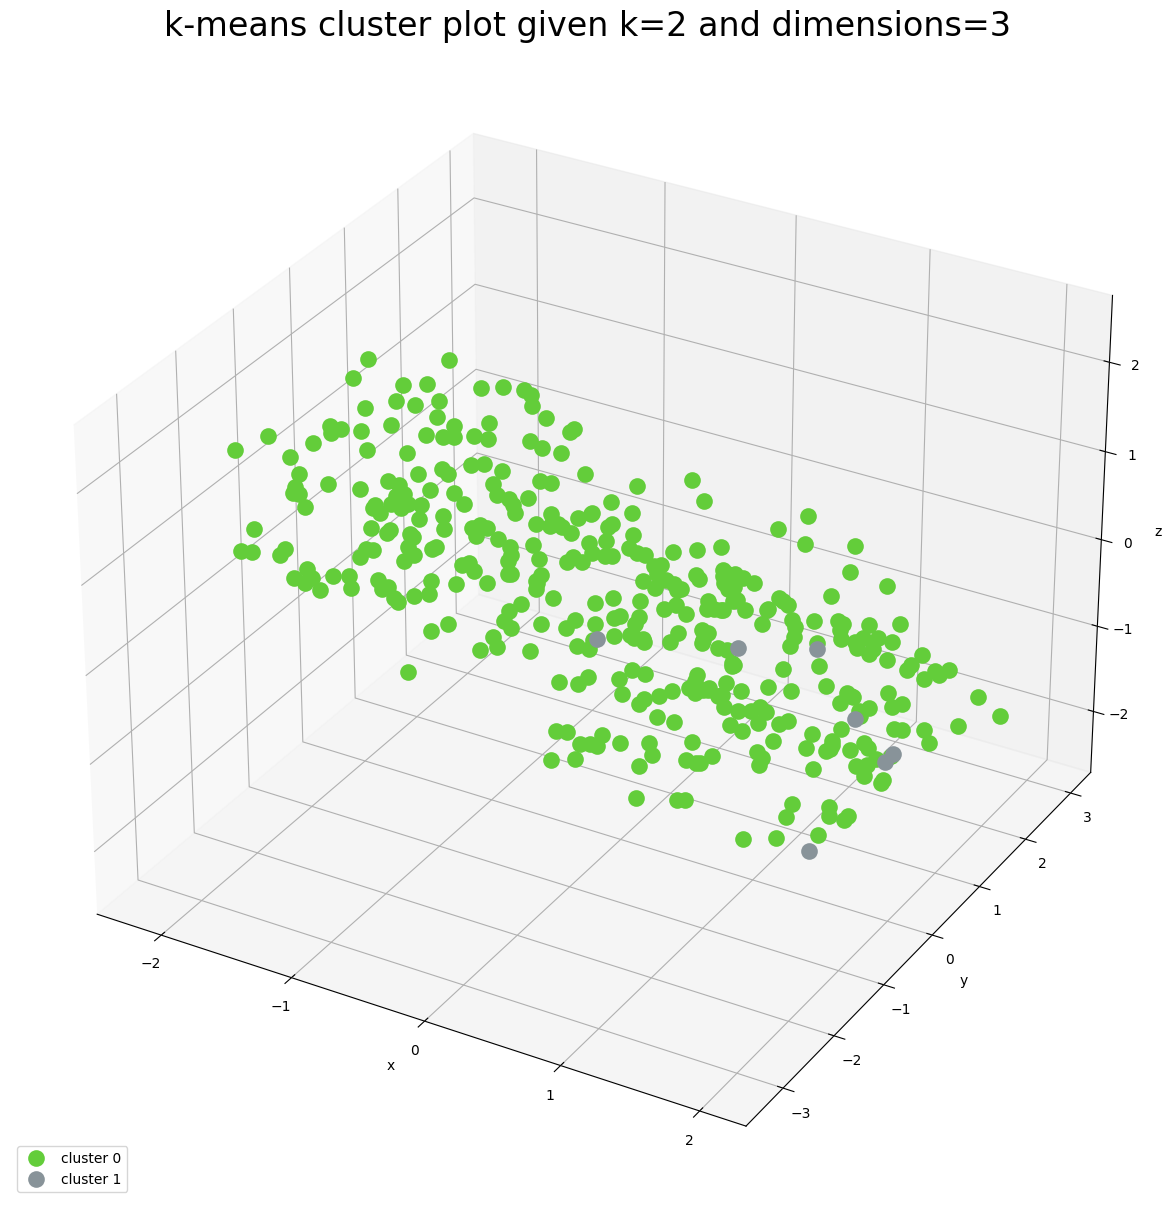

In [66]:
clusters2 = plot_kmeans(tfidf_matrix=tfidf_matrix, titles=titles, k_value=2, dimensions=3)

In [67]:
clusters2[clusters2.Cluster==1]

Cluster          Doc Name  \
10        1            Barolo   
17        1             Porto   
35        1       Napa Valley   
11        1             Rioja   
4         1           Chianti   
9         1           Mendoza   
7         1  Ribera del Duero   

                                                 Text  
10  barolo la spinettta top_line barolo open last_...  
17  44 outstanding_quality tawny_port clear aroma ...  
35  wow big_bold beautiful dark_fruit oak pepper v...  
11  oak mint red_fruit smooth long last nice mediu...  
4   limited experience excellent representation ch...  
9   chair crew argentina malbec look try argentina...  
7   thursday pregame show bring erro think ygay 09...

In [86]:
not_cluster1 = df2[df2.label.isin[cluster1.label.unique()]] # df[~df.country.isin(countries_to_keep)]

TypeError: 'method' object is not subscriptable

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


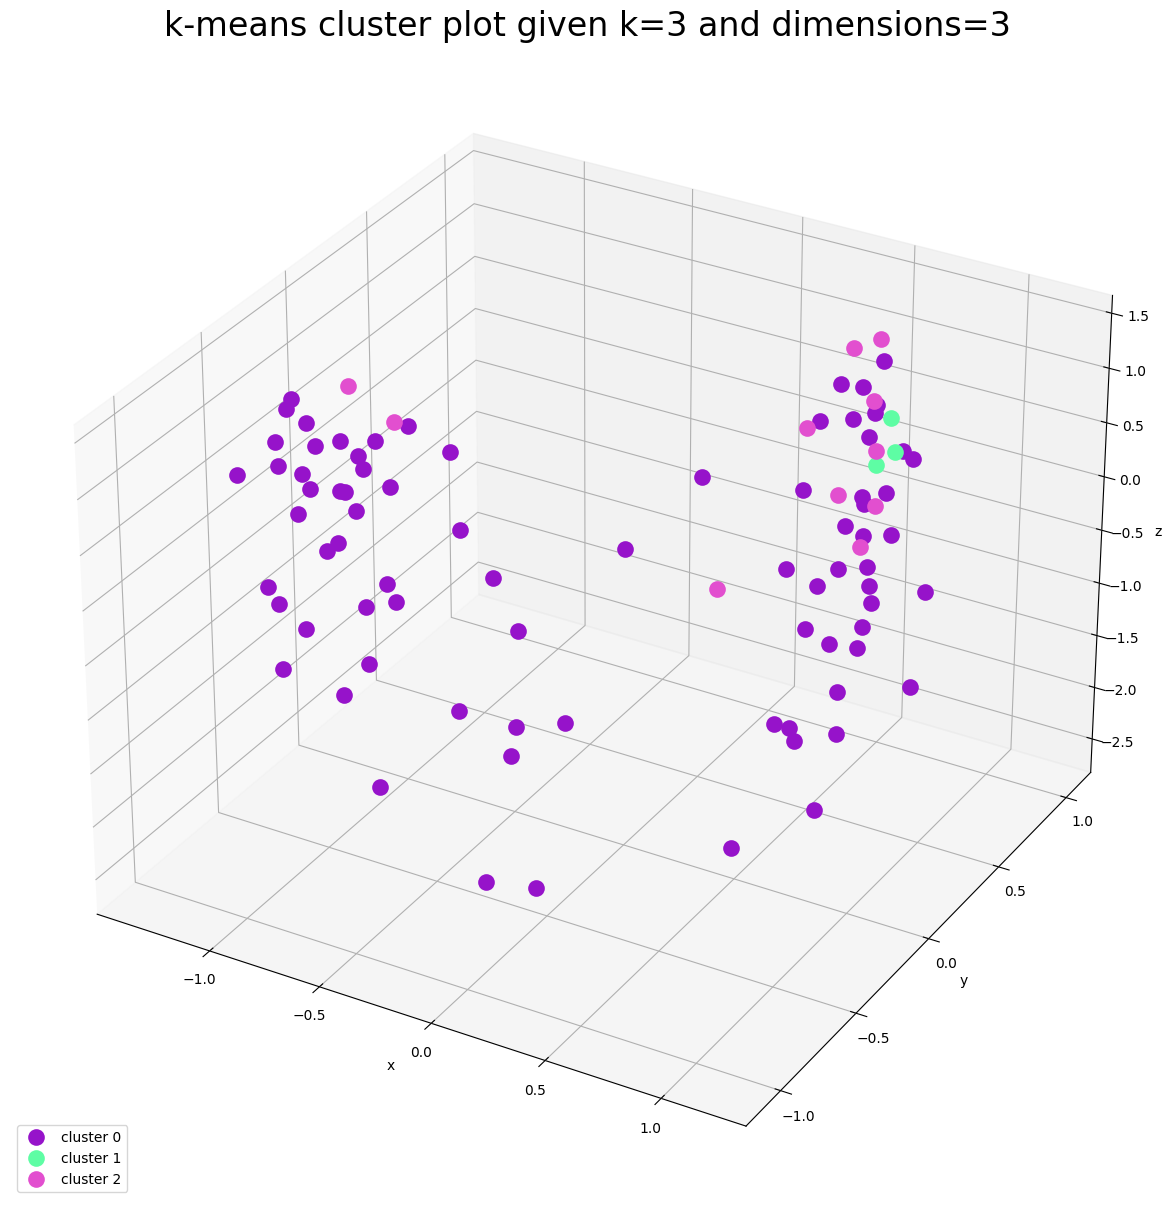

In [69]:
clusters3 = plot_kmeans(tfidf_matrix=tfidf_matrix, titles=titles, k_value=3, dimensions=3)

In [92]:
clusters3[clusters3.Cluster==0]

Cluster                    Doc Name  \
0         0         France Chenin Blanc   
66        0             Italy Primitivo   
65        0        Australia Pinot Noir   
64        0          Chile Shiraz/Syrah   
63        0         Italy Montepulciano   
..      ...                         ...   
40        0            Austria Riesling   
37        0  United States Chenin Blanc   
38        0    United States Pinot Gris   
39        0       Spain Sauvignon Blanc   
28        0    Chile Cabernet Sauvignon   

                                                 Text  
0   light_yellow citrus honey pear_citrus apple un...  
66  medium_ruby medium blueberry blueberry wet lea...  
65  medium_ruby_red intense nose strawberry cherry...  
64  ruby black_cherry prune spicy note bit warm al...  
63  dark red color red_fruit combination licorice ...  
..                                                ...  
40  2020 riesling pale_lemon_medium_intensity nose...  
37  nv chenin_blanc medium_intense orange colour m...  
38  2021 pinot_gris pale_lemon_green_medium pronou...  
39  2020 sauvignon_blanc pale_gold medium pronounc...  
28  park hotel restaurant voss norway fantastic ce...  

[79 rows x 3 columns]

In [114]:
cluster0 = df2[df2.label.isin(list(clusters3[clusters3.Cluster==0]['Doc Name'].unique()))]
cluster0_vectorizer = vectorizer
text_for_counts_cluster0 = cluster0.processed_text_str.values.tolist()
matrix_cluster0 = cluster0_vectorizer.fit_transform(text_for_counts_cluster0)
words_cluster0 = cluster0_vectorizer.get_feature_names_out()
doc_term_df_cluster0 = pd.DataFrame(matrix_cluster0.toarray(), columns=words_cluster0, index=cluster0.index)
topN_tfidf_cluster0 = pd.DataFrame(doc_term_df_cluster0.mean().sort_values(ascending=False).head(25))
topN_tfidf_cluster0.rename(columns={0: 'Cluster 0 Mean TF-IDF'}, inplace=True)
topN_tfidf_cluster0.head(25)

Cluster 0 Mean TF-IDF
palate                  0.139881
note                    0.135242
dry                     0.127911
nice                    0.109842
acidity                 0.099729
light                   0.091623
great                   0.088327
hint                    0.080372
balance                 0.077879
like                    0.071981
flavor                  0.069333
smooth                  0.068336
red                     0.067556
fresh                   0.067054
well                    0.066256
aroma                   0.064997
medium                  0.064816
vanilla                 0.063548
white                   0.062321
fruity                  0.061925
lemon                   0.061720
sweet                   0.060245
honey                   0.059423
red_fruit               0.056354
tannin                  0.054483

In [113]:
clusters3[clusters3.Cluster==1]

Cluster           Doc Name  \
3        1   Italy Sangiovese   
2        1     Italy Nebbiolo   
6        1  Spain Tempranillo   

                                                Text  
3  limited experience excellent representation ch...  
2  young good 42 potential become outstanding tan...  
6  thursday pregame show bring erro think ygay 09...

In [109]:
cluster1 = pd.concat([df2[df2.label=='Italy Sangiovese'], df2[df2.label=='Italy Nebbiolo'], df2[df2.label=='Spain Tempranillo']])
cluster1_vectorizer = vectorizer
text_for_counts_cluster1 = cluster1.processed_text_str.values.tolist()
matrix_cluster1 = cluster1_vectorizer.fit_transform(text_for_counts_cluster1)
words_cluster1 = cluster1_vectorizer.get_feature_names_out()
doc_term_df_cluster1 = pd.DataFrame(matrix_cluster1.toarray(), columns=words_cluster1, index=cluster1.index)
topN_tfidf_cluster1 = pd.DataFrame(doc_term_df_cluster1.mean().sort_values(ascending=False).head(25))
topN_tfidf_cluster1.rename(columns={0: 'Cluster 1 Mean TF-IDF'}, inplace=True)
topN_tfidf_cluster1.head(25)

Cluster 1 Mean TF-IDF
dry                     0.231139
tannin                  0.223609
palate                  0.204600
red                     0.192663
note                    0.184017
leather                 0.181943
nice                    0.166381
great                   0.165786
red_fruit               0.163062
vanilla                 0.149285
plum                    0.147274
acidity                 0.138535
balance                 0.134959
tobacco                 0.131878
smooth                  0.129354
well                    0.126286
spice                   0.123460
still                   0.118066
hint                    0.113743
barolo                  0.106569
medium                  0.100819
chianti                 0.097819
ripe                    0.096766
flavor                  0.095209
light                   0.093943

In [93]:
clusters3[clusters3.Cluster==2]

Cluster                          Doc Name  \
5         2                      France Gamay   
1         2                 France Pinot Noir   
4         2                 France Chardonnay   
13        2         Portugal Touriga Nacional   
43        2               France Shiraz/Syrah   
12        2  United States Cabernet Sauvignon   
17        2                  Germany Riesling   
23        2                  Argentina Malbec   
25        2          United States Pinot Noir   
7         2            Australia Shiraz/Syrah   
46        2        United States Shiraz/Syrah   

                                                 Text  
5   max niet heeeel veeel body maar een perfect zo...  
1   top_quality grape meet expertise winemaker get...  
4   beautiful complex nicely_balance sophisticated...  
13  44 outstanding_quality tawny_port clear aroma ...  
43  2017 state_syrah deep_ruby medium_intensity no...  
12  44 outstanding_quality california cs 100_caber...  
17  colour lightly golden nose mineral slightly ar...  
23  qpr alert nose tart_cherry dark_fruit mixed va...  
25  everything_want pinot lean french oregonwashin...  
7   shiraz 50 barossa 50 eden_valley abv 145 begin...  
46  saturday intense flavor blac berry blueberry b...

In [111]:
cluster2 = df2[df2.label.isin(list(clusters3[clusters3.Cluster==2]['Doc Name'].unique()))]
cluster2_vectorizer = vectorizer
text_for_counts_cluster2 = cluster2.processed_text_str.values.tolist()
matrix_cluster2 = cluster2_vectorizer.fit_transform(text_for_counts_cluster2)
words_cluster2 = cluster2_vectorizer.get_feature_names_out()
doc_term_df_cluster2 = pd.DataFrame(matrix_cluster2.toarray(), columns=words_cluster2, index=cluster2.index)
topN_tfidf_cluster2 = pd.DataFrame(doc_term_df_cluster2.mean().sort_values(ascending=False).head(25))
topN_tfidf_cluster2.rename(columns={0: 'Cluster 2 Mean TF-IDF'}, inplace=True)
topN_tfidf_cluster2.head(25)

Cluster 2 Mean TF-IDF
palate                   0.216260
note                     0.190472
dry                      0.167713
nice                     0.165142
great                    0.163231
smooth                   0.140207
acidity                  0.139462
balance                  0.138460
tannin                   0.134284
vanilla                  0.128003
red                      0.127453
plum                     0.122173
spice                    0.121304
hint                     0.119476
light                    0.116918
well                     0.116585
flavor                   0.116399
sweet                    0.112564
red_fruit                0.104600
like                     0.103695
medium                   0.097785
ripe                     0.093846
blackberry               0.093211
still                    0.090112
aroma                    0.087170

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


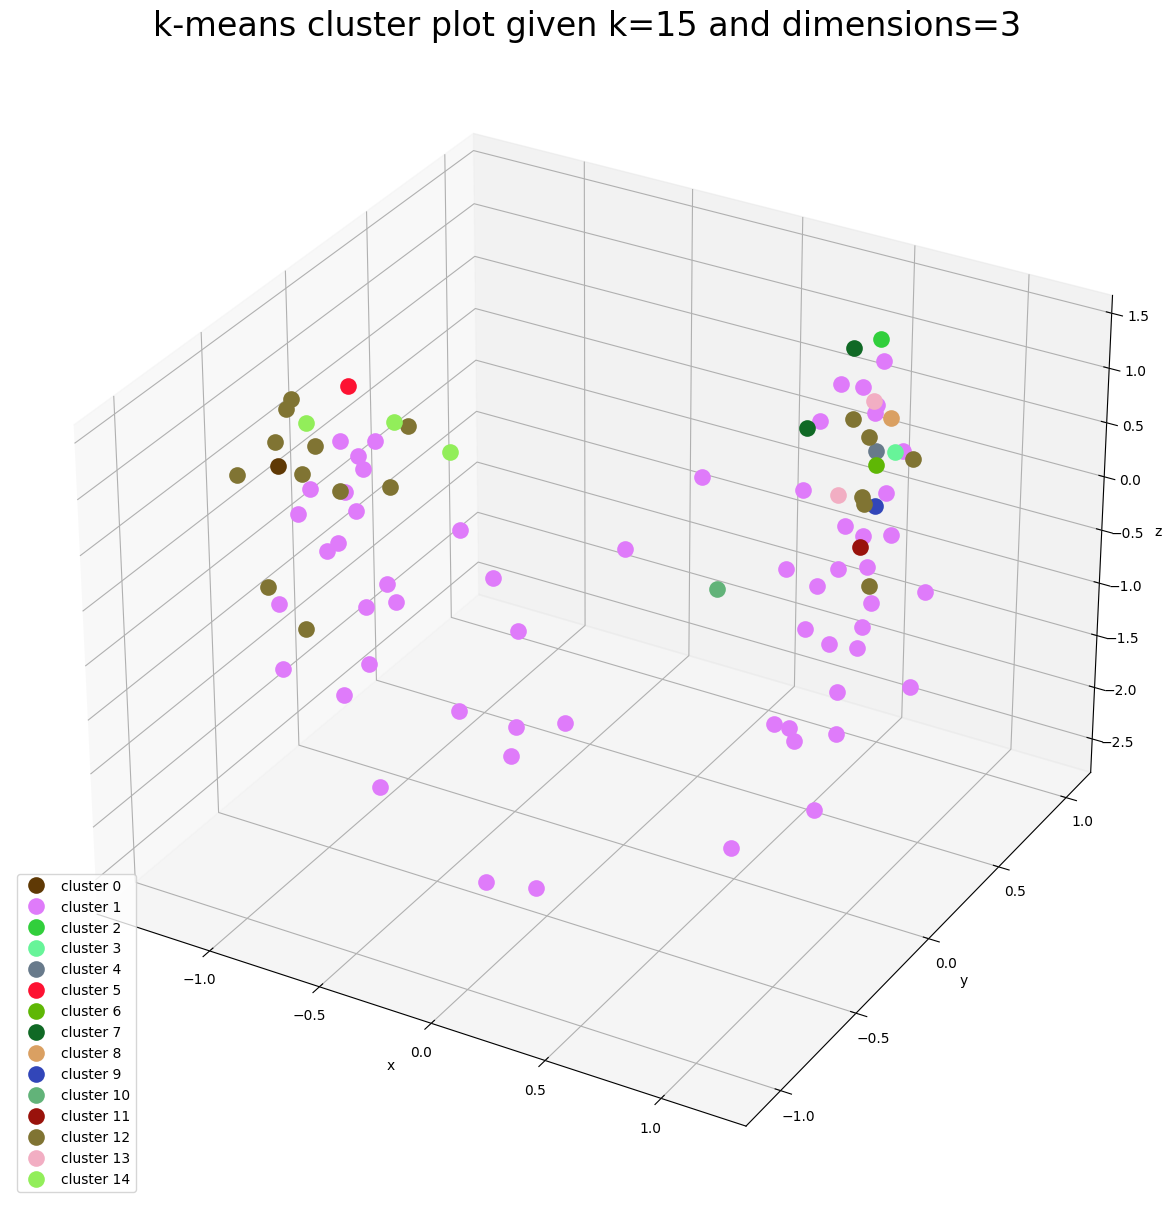

In [46]:
clusters14 = plot_kmeans(tfidf_matrix=tfidf_matrix, titles=titles, k_value=15, dimensions=3)

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


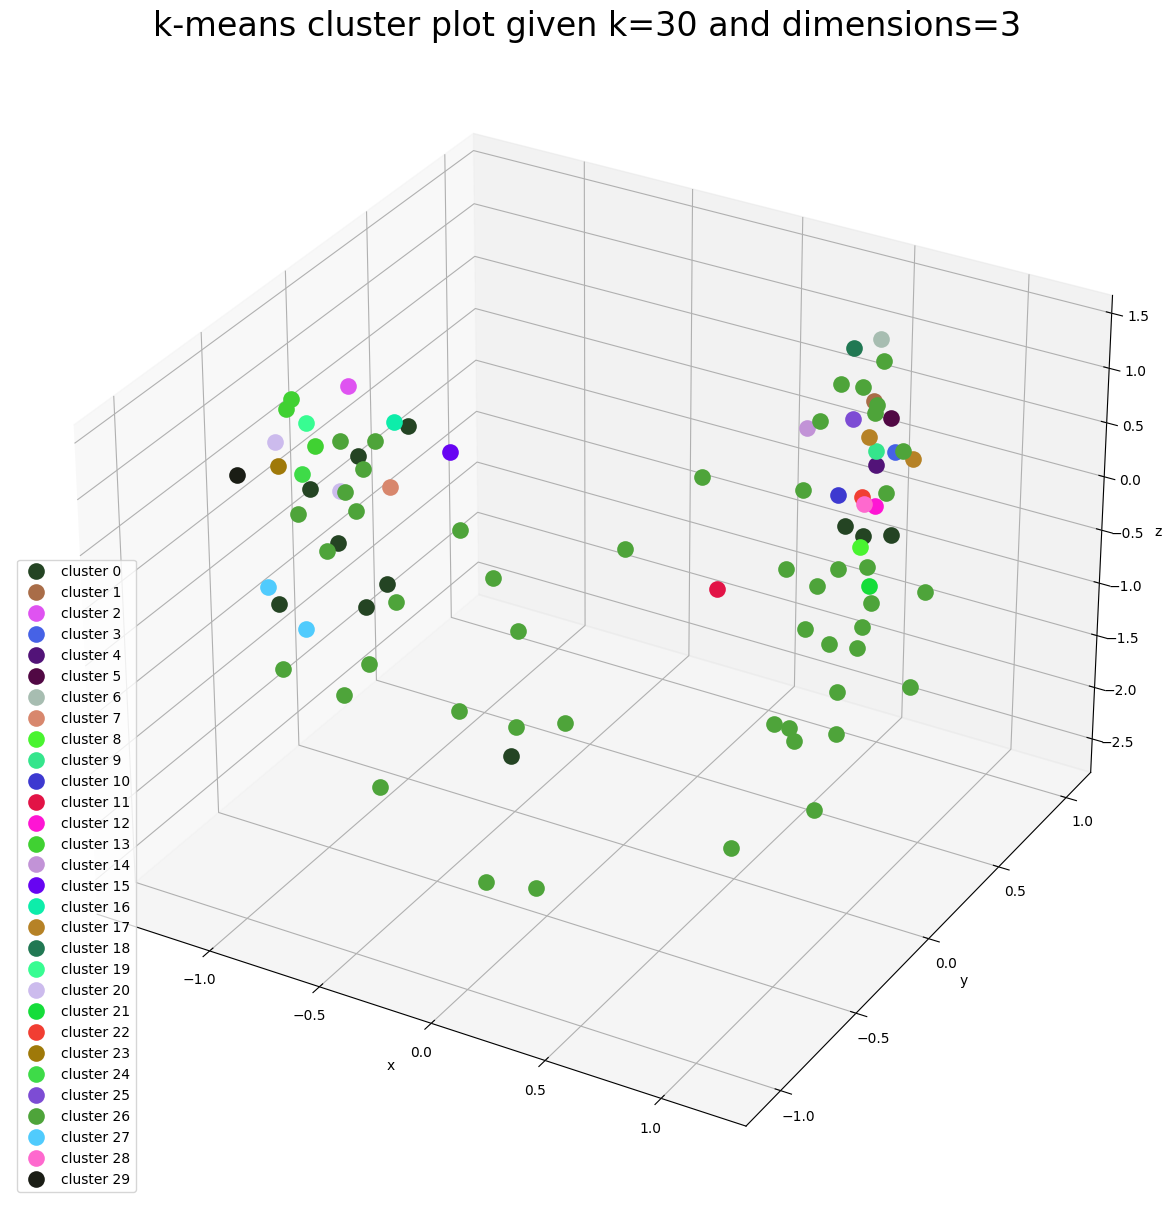

In [47]:
clusters14 = plot_kmeans(tfidf_matrix=tfidf_matrix, titles=titles, k_value=30, dimensions=3)

## Cluster by Region

In [48]:
print('plotting clusters of {df.Region.unique()} unique Regions . . .')

plotting clusters of {df.Region.unique()} unique Regions . . .


In [49]:
bbs = {}

for region in df.Region.unique():
    bb_string = " ".join(df[df['Region']==region].processed_text_str.values)
    bbs[region] = bb_string
    
new_df_with_394_points = pd.DataFrame([bbs.keys(), bbs.values()]).T
new_df_with_394_points.rename(columns={0: "Region",
                                      1: "processed_text_str"}, inplace=True)

bb_vectorizer = TfidfVectorizer(use_idf=True,
                                min_df=1,
                                norm=None)

magic = new_df_with_394_points.processed_text_str.values.tolist()
transformed_corpus = bb_vectorizer.fit_transform(magic)

transformed_corpus_as_array = transformed_corpus.toarray()

tfidf_matrix = transformed_corpus.todense()

titles = new_df_with_394_points['Region'].tolist()
final_processed_text = [xyz for xyz in new_df_with_394_points['processed_text_str']]

In [50]:
tfidf_matrix.shape

(394, 140347)

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


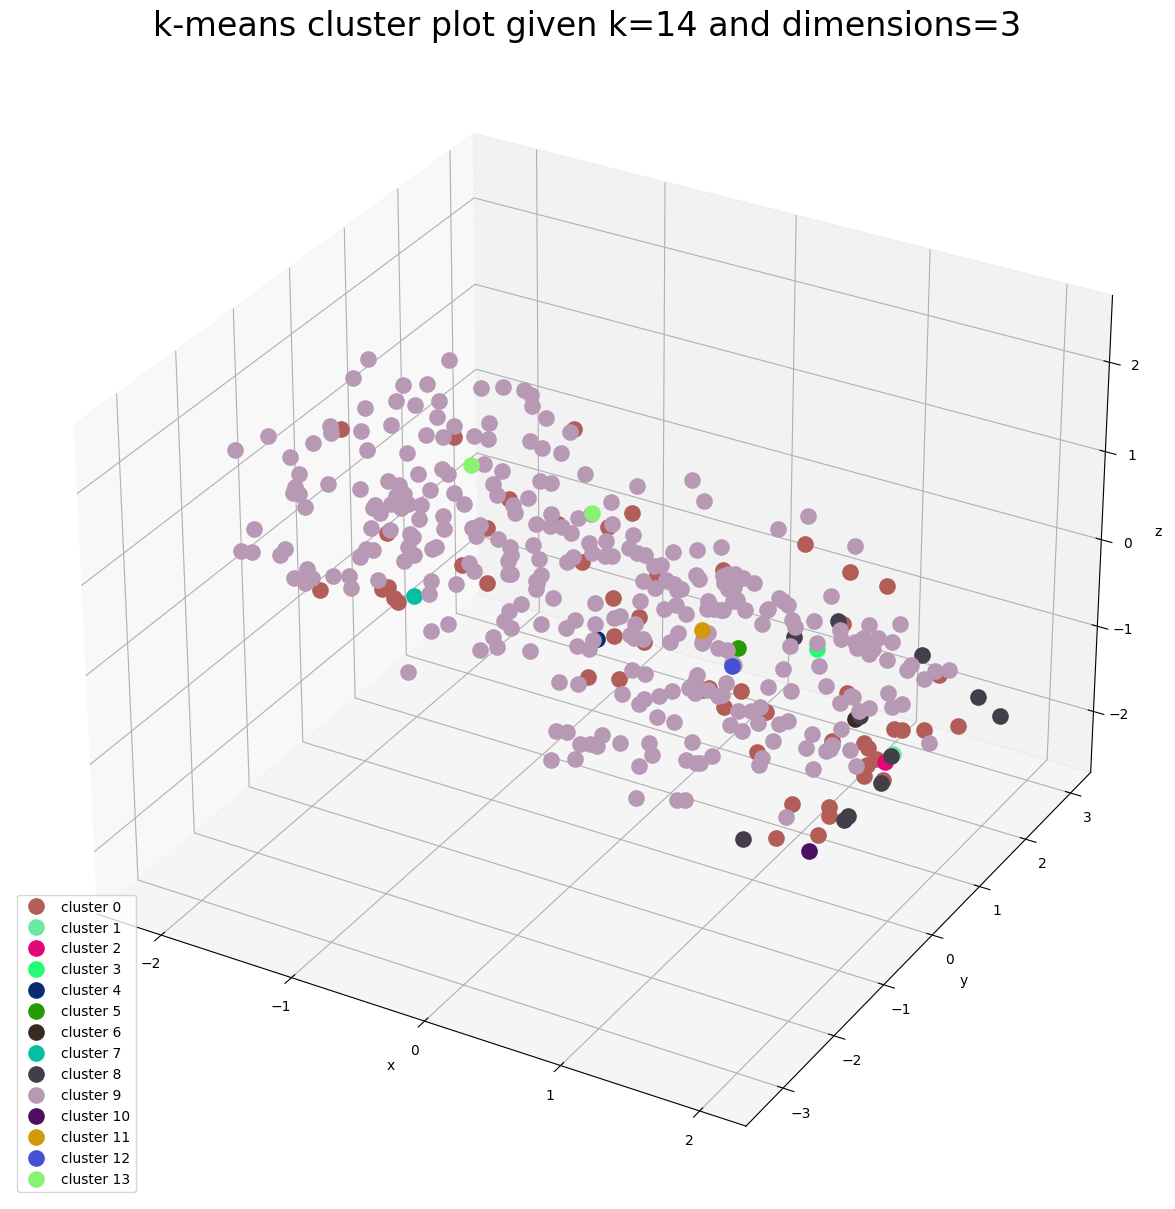

In [51]:
clusters14 = plot_kmeans(tfidf_matrix=tfidf_matrix, titles=titles, k_value=14, dimensions=3)

In [53]:
clusters14[clusters14.Cluster==9].merge(df[['Country', 'Region']], how='left', left_on="Doc Name", right_on = 'Region').Country.unique()

array(['United States', 'France', 'Australia', 'Chile', 'Italy', 'Spain',
       'South Africa', 'Argentina', 'New Zealand', 'Portugal', 'Canada',
       'Germany', 'Israel', 'Austria'], dtype=object)

In [54]:
clusters14[clusters14.Cluster==9].merge(df[['Price_Cat', 'Region']], how='left', left_on="Doc Name", right_on = 'Region').Price_Cat.unique()

array(['low_price', 'price_high', 'medium_price', 'price_unknown',
       'cheap'], dtype=object)

In [55]:
clusters14[clusters14.Cluster==9].merge(df[['Single_Most_Used_Grape', 'Region']], how='left', left_on="Doc Name", right_on = 'Region').Single_Most_Used_Grape.unique()

array(['Pinot Noir', 'Shiraz/Syrah', 'Viognier', 'Chenin Blanc',
       'Cabernet Franc', 'Cabernet Sauvignon', 'Sauvignon Blanc',
       'Chardonnay', 'Sangiovese', 'Nebbiolo', 'Arneis', 'Riesling',
       'Tempranillo', 'Pinot Gris', 'Pinot Grigio', 'Malbec', 'Trebbiano',
       'Grenache', 'Malvasia', 'Primitivo', 'Baga', 'Gamay',
       'Grenache Blanc', 'Melon de Bourgogne', 'Corvina', 'Roussanne',
       'Arinto de Bucelas', 'Petit Verdot', 'Montepulciano', 'Aragonez'],
      dtype=object)

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


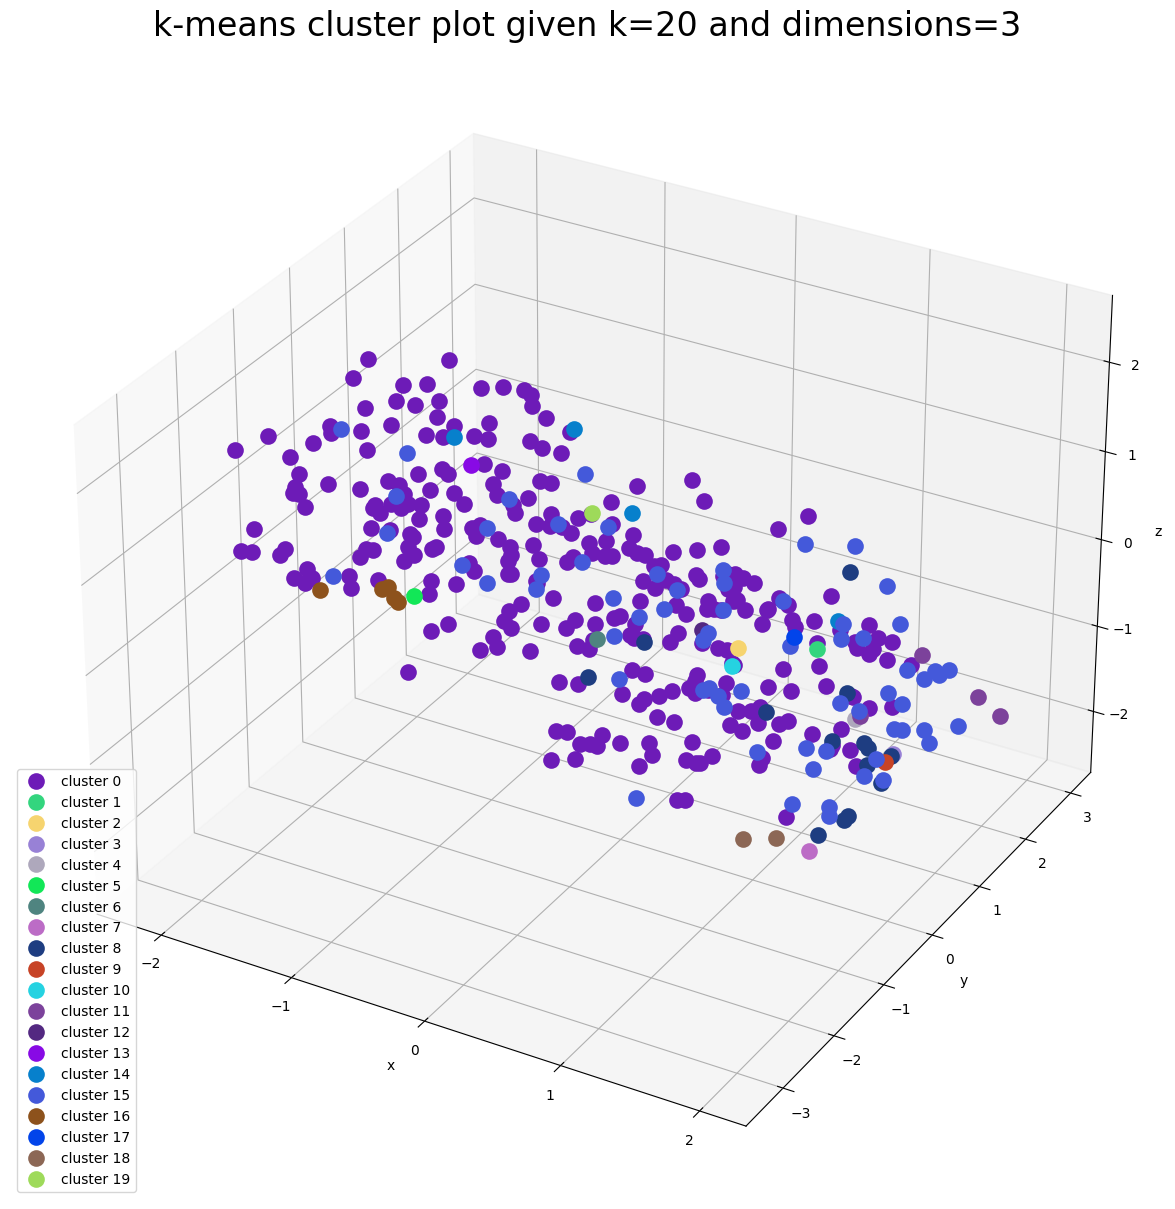

In [56]:
clusters20 = plot_kmeans(tfidf_matrix=tfidf_matrix, titles=titles, k_value=20, dimensions=3)

In [57]:
clusters20.head(93)

Cluster                     Doc Name  \
393        0  Meursault 1er Cru 'Porusot'   
216        0        Friuli-Venezia Giulia   
330        0             Dry Creek Valley   
214        0      South Eastern Australia   
213        0             Eola-Amity Hills   
..       ...                          ...   
289        0     Yamhill-Carlton District   
287        0  Bâtard-Montrachet Grand Cru   
286        0                   Washington   
285        0                Yakima Valley   
284        0                 Yarra Valley   

                                                  Text  
393  nice fresh meursault nice acidity little oak s...  
216  pale_lemon orangeness pear_apple stone honey l...  
330  still drink alright acidity hint melon supple ...  
214  med young purple_color oof similar last_review...  
213  clear_medium_ruby_color clean nose medium_inte...  
..                                                 ...  
289  ufff beautiful ruby_color maroon border except...  
287  44 time bring big_gun_beauty complexity combin...  
286  87 pale_yellow hello ripe peach_lime candy flo...  
285  87 lime jelly bean honey nectarine green pear ...  
284  innocent bystander yarra king valley handpicke...  

[93 rows x 3 columns]

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


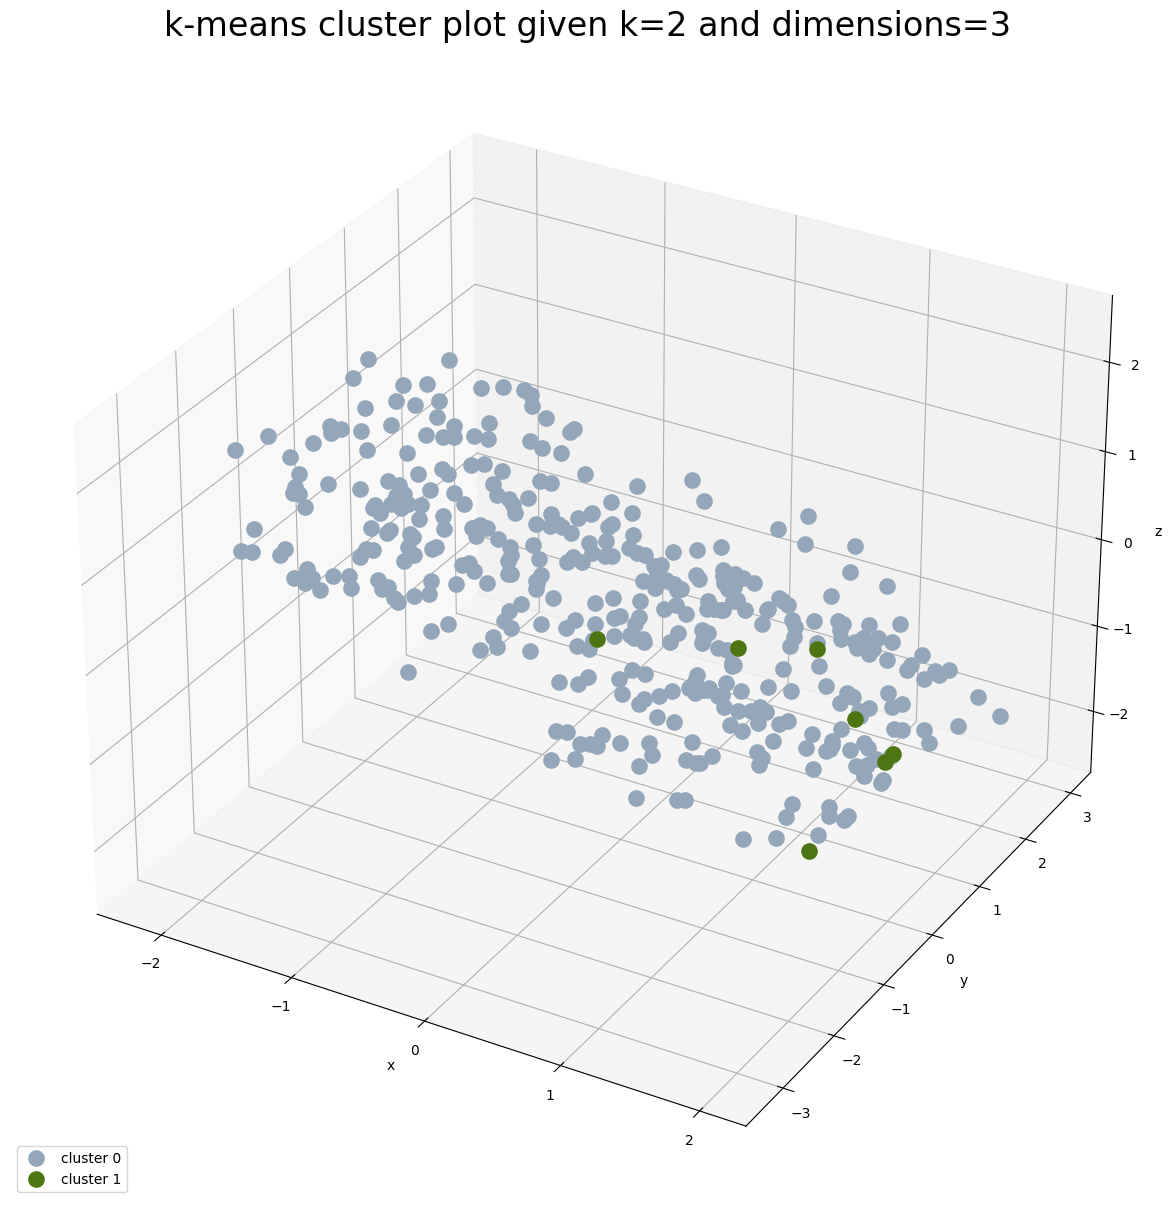

In [58]:
clusters2 = plot_kmeans(tfidf_matrix=tfidf_matrix, titles=titles, k_value=2, dimensions=3)

In [59]:
clusters2.head(100)

Cluster                Doc Name  \
0          0                 Vouvray   
267        0         Okanagan Valley   
266        0       Côtes de Provence   
265        0                Juliénas   
264        0  Minervois La Livinière   
..       ...                     ...   
245        0                  Marche   
294        0            Clare Valley   
295        0                Piemonte   
296        0               Grampians   
366        0                 Luberon   

                                                  Text  
0    light_yellow citrus honey pear_citrus apple un...  
267  okanagan country bonanza dark_purple red_colou...  
266  decent gsc blend pale coral color bouquet stra...  
265  9 45 excellent cru bojo pair squid spicy nduja...  
264  minervois la liviniere aop syrah carignan et g...  
..                                                 ...  
245  100 biancame first_time drink grape must say g...  
294  actually bit woodiness quite dry dunno easy di...  
295  entry_level nebbiolo classic master bruno_giac...  
296  06 vintage med_intensity pepper black_fruit ol...  
366  good balance freshness roundness bit creamy le...  

[100 rows x 3 columns]

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


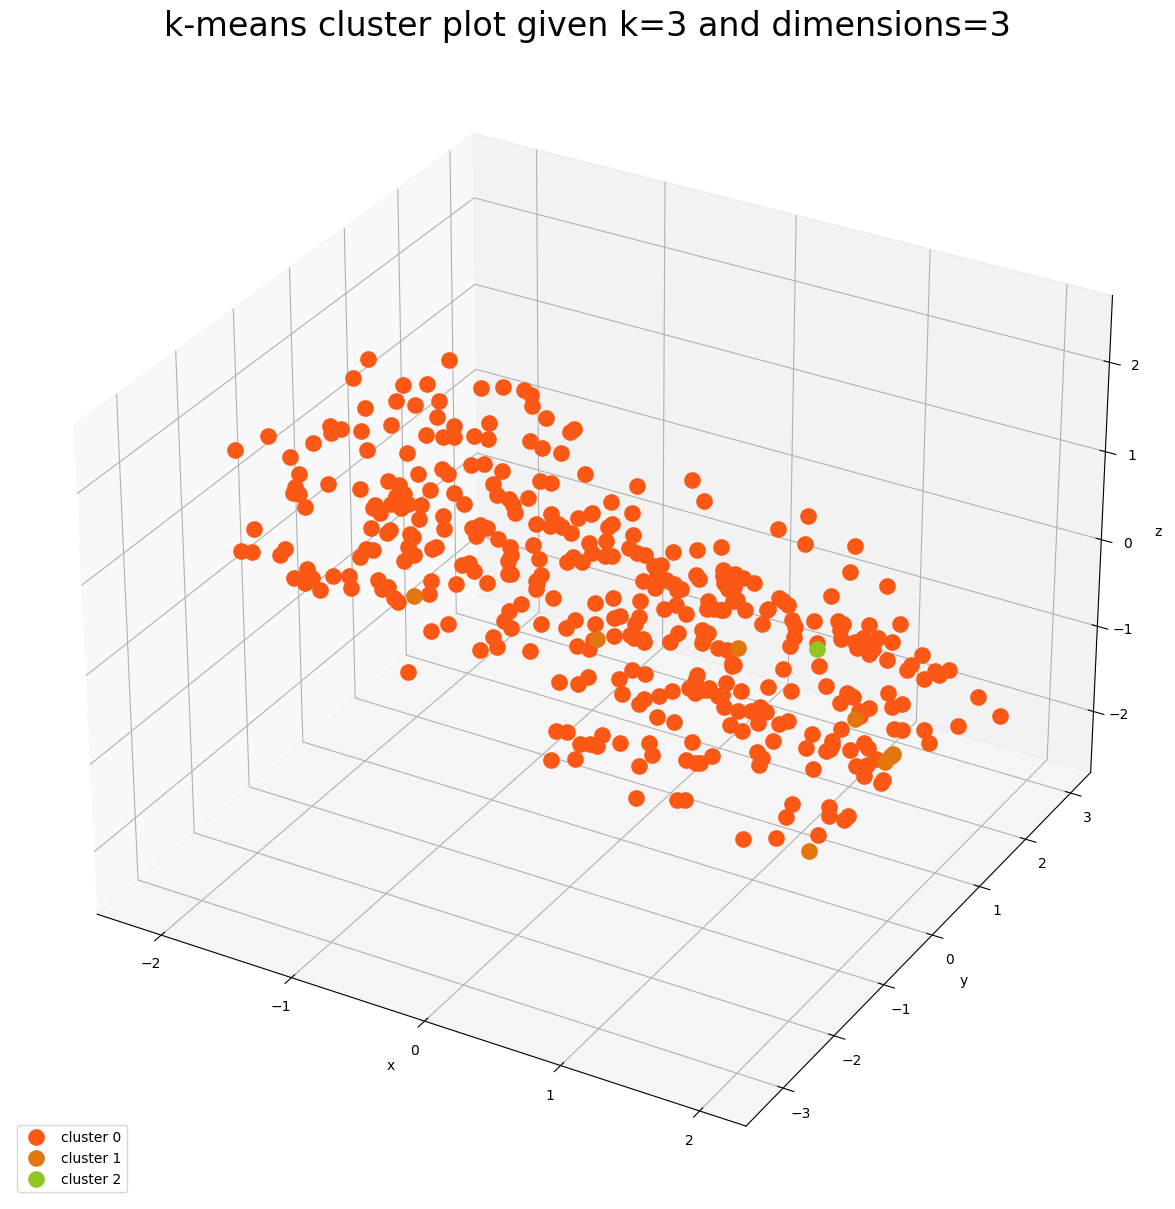

In [61]:
clusters3 = plot_kmeans(tfidf_matrix=tfidf_matrix, titles=titles, k_value=3, dimensions=3)

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


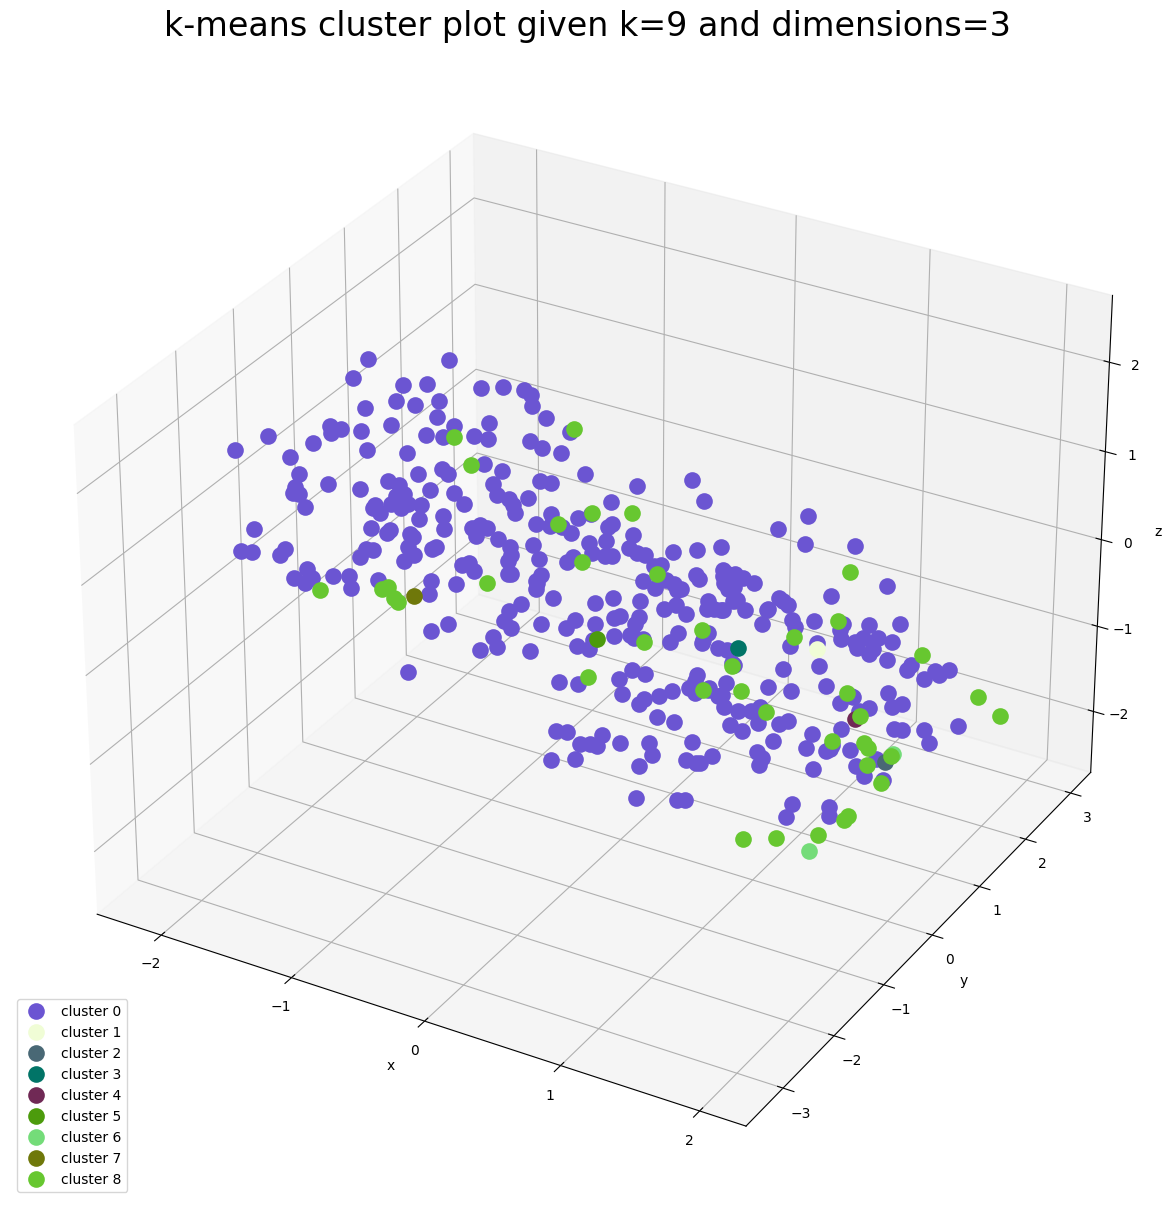

In [62]:
clusters9 = plot_kmeans(tfidf_matrix=tfidf_matrix, titles=titles, k_value=9, dimensions=3)

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


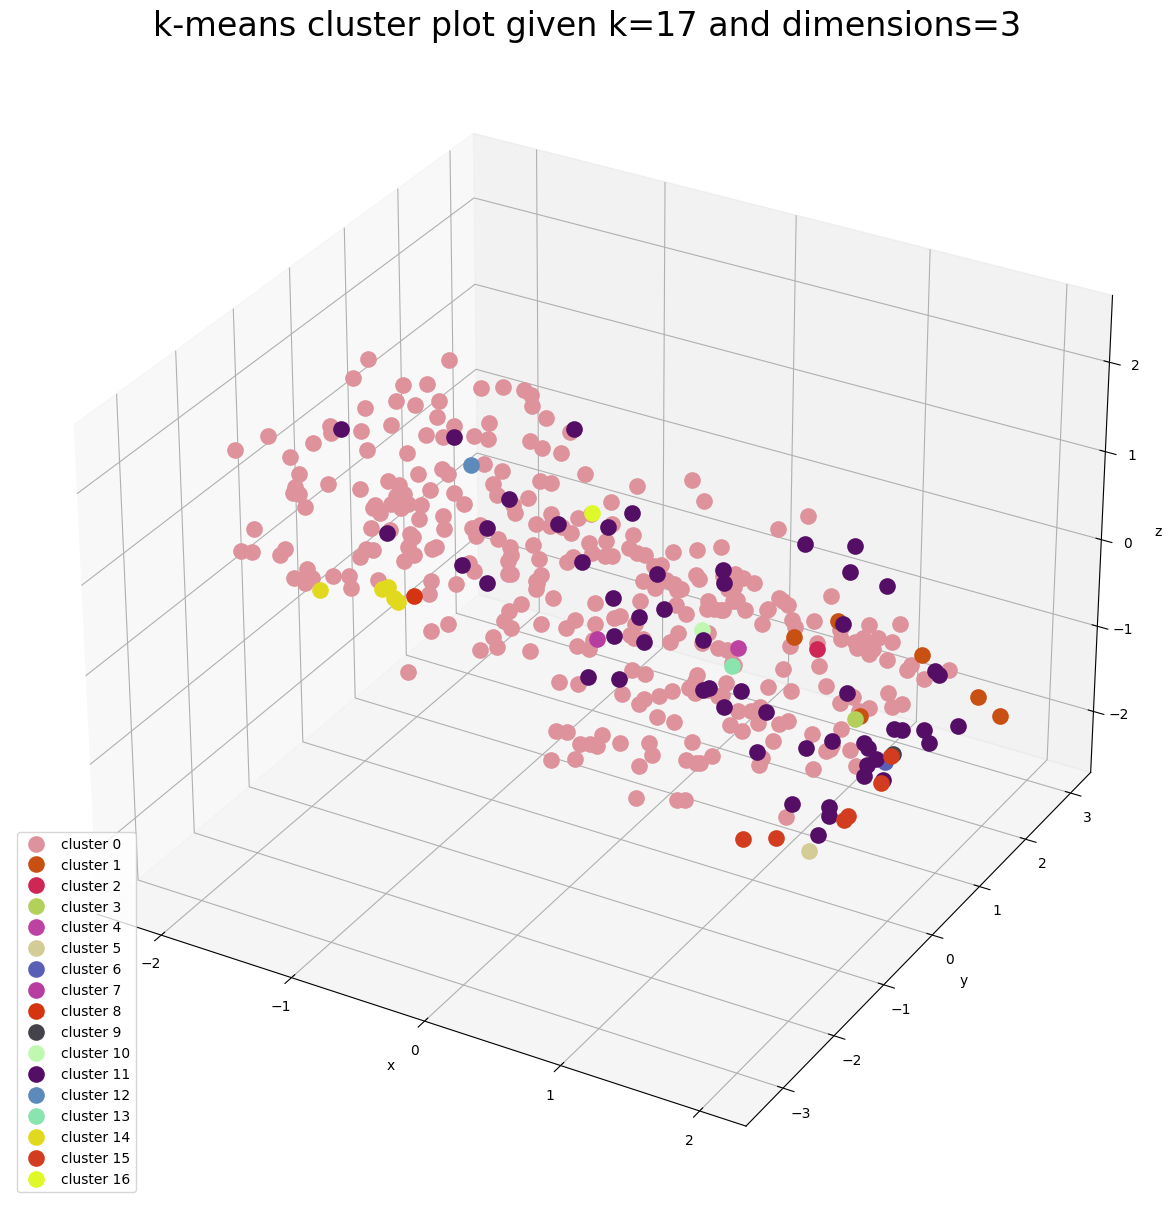

In [63]:
clusters10 = plot_kmeans(tfidf_matrix=tfidf_matrix, titles=titles, k_value=17, dimensions=3)

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.


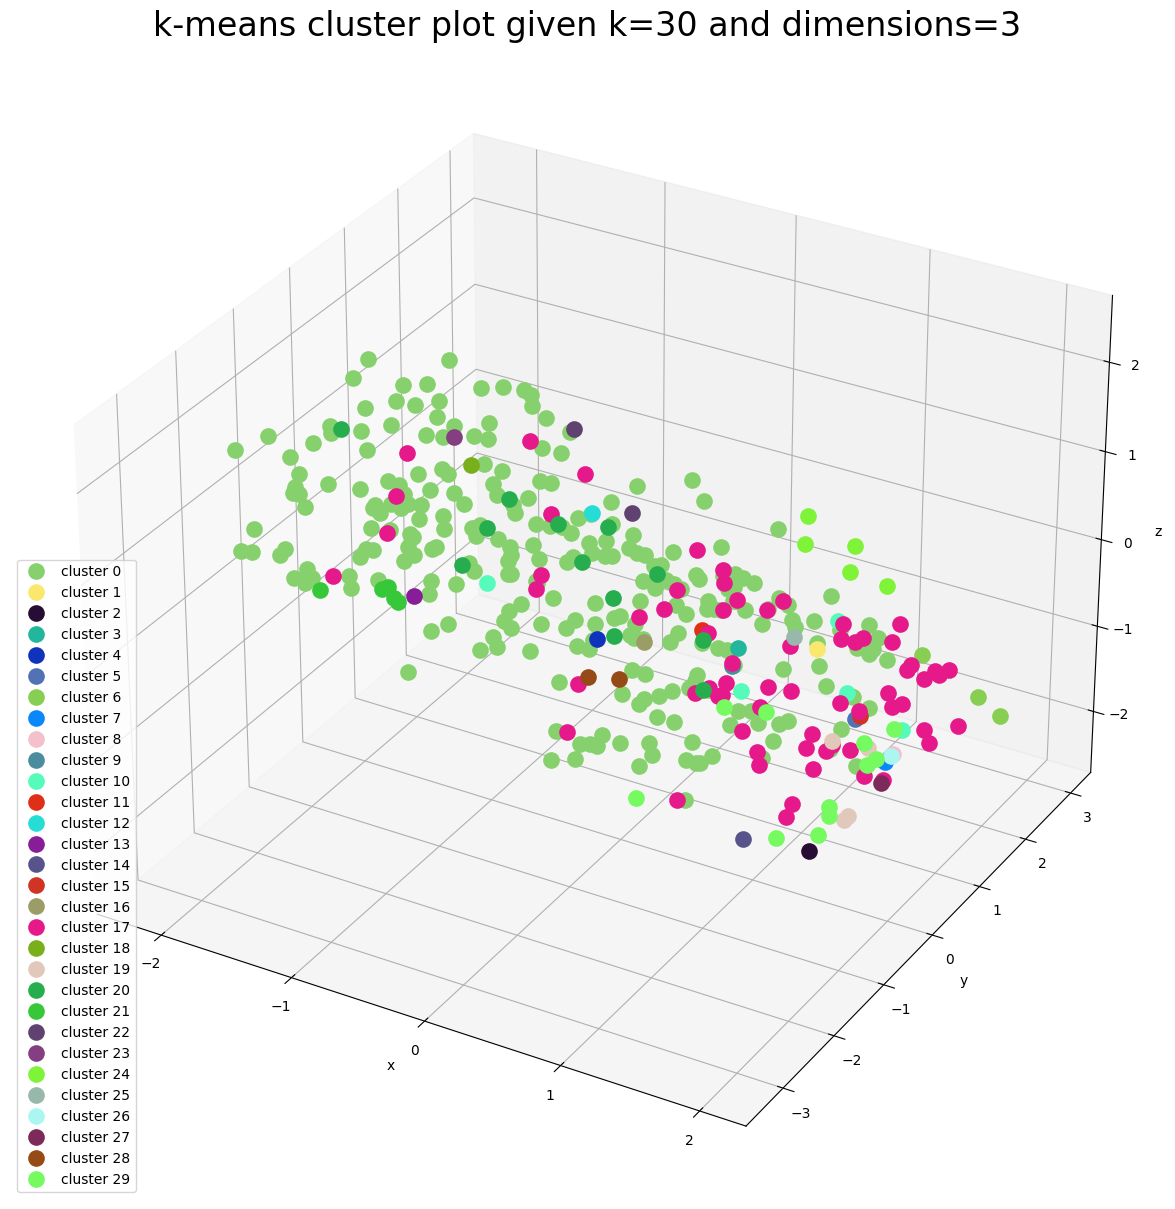

In [64]:
clusters30 = plot_kmeans(tfidf_matrix=tfidf_matrix, titles=titles, k_value=30, dimensions=3)

In [65]:
asctime()

'Mon May  1 11:17:48 2023'